<a href="https://colab.research.google.com/github/LIONPANJSHIR/ML/blob/main/diabete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


Le diabète est une maladie chronique qui constitue aujourd’hui un enjeu majeur de santé publique à l’échelle mondiale. Son dépistage précoce et sa prise en charge rapide permettent de réduire considérablement les risques de complications graves. Dans ce contexte, l’analyse de données médicales et l’utilisation de modèles prédictifs constituent des outils puissants pour soutenir les professionnels de santé.


---

### Contexte et enjeux

Le jeu de données provient de l’**Institut National du Diabète et des Maladies Digestives et Rénales (National Institute of Diabetes and Digestive and Kidney Diseases)**.
L’objectif est de **prédire si une patiente est atteinte de diabète ou non**, à partir de mesures cliniques (comme la glycémie, la pression artérielle, l’indice de masse corporelle, etc.).

Quelques points importants :

* Toutes les patientes sont des **femmes âgées d’au moins 21 ans**, d’origine **Pima (une communauté amérindienne)**.
* Le diabète est une **maladie chronique** ayant un fort impact sur la santé publique. Pouvoir prédire sa présence à partir de données médicales peut aider à **anticiper, prévenir et mieux prendre en charge** les patientes.

L’enjeu principal est donc à la fois **médical et sociétal** : développer un modèle capable d’identifier au mieux les patientes à risque, tout en minimisant les erreurs (faux négatifs = patientes diabétiques non détectées).

---

### Démarche du projet

Pour atteindre cet objectif, nous allons suivre les grandes étapes suivantes :

1. **Exploration et nettoyage des données**

   * Vérifier les valeurs manquantes, aberrantes
   * Analyser la distribution des variables (EDA – *Exploratory Data Analysis*).

2. **Préparation des données**

   * Normalisation ou standardisation si nécessaire.
   * Remplacer ou imputer certaines valeurs.
   * Gestion du déséquilibre de classes (car les patientes diabétiques sont moins nombreuses).
   * Découpage en **jeu d’entraînement** et **jeu de test**.

3. **Construction des modèles de machine learning**

   * Tester plusieurs algorithmes (régression logistique, Random Forest, Gradient Boosting, etc.).
   * Utiliser des techniques de **validation croisée** et de **recherche d’hyperparamètres** (Optuna, GridSearch, BayesSearch).
   * Comparer les performances selon différents critères (précision, rappel, F1-score, AUC).

4. **Optimisation des seuils de décision**

   * Ajuster le seuil de classification pour trouver un compromis entre **précision et rappel**.
   * Mettre l’accent sur le **rappel** (ne pas manquer de patientes diabétiques), tout en maintenant une précision minimale.

5. **Évaluation finale et interprétation**

   * Évaluer le modèle sur le jeu de test.
   * Interpréter les résultats (quelles variables influencent le plus le diagnostic).
   * Discussion sur les limites (données limitées à une population spécifique, biais possibles).

---

 En résumé :
Ce projet vise à construire un modèle robuste capable de prédire le diabète chez les femmes Pima à partir de mesures médicales. Il combine des **enjeux médicaux réels** et des **méthodologies avancées de data science**, en mettant l’accent sur la qualité des prédictions et l’équilibre entre rappel et précision.

---


source : [ici](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data)

###Module

In [4]:
# ⚡ Manipulation des données
import pandas as pd
import numpy as np
from collections import Counter

# ⚡ Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ⚡ Modèles ML
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# ⚡ Préprocessing & Pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# ⚡ Optimisation d'hyperparamètres
!pip install optuna
!pip install scikit-optimize
!pip install hyperopt
!pip install bayesian-optimization
!pip install skopt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import optuna

# ⚡ Évaluation des modèles
from sklearn.metrics import classification_report, f1_score, recall_score, make_scorer, precision_score, confusion_matrix, roc_auc_score, accuracy_score

# ⚡ Sauvegarde / chargement de modèles
import joblib

# ⚡ Suppression des warnings inutiles
import warnings
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


# EDA

In [5]:
### Data
df=pd.read_csv('diabetes.csv')

In [6]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
df.describe().T

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Outcome                     0.0000    1.00000    1.00



* Le jeu de données contient **768 observations**, ce qui en fait un échantillon relativement petit pour une modélisation robuste.
* Aucune valeur manquante explicite n’est détectée à première vue.
* Toutes les variables explicatives sont de type **numérique continue**, tandis que la variable cible est **binaire** :

  * `0` : patiente saine
  * `1` : patiente atteinte de diabète
* Toutefois, certaines incohérences apparaissent dans les données : par exemple, des valeurs **nulles** ou **inhabituelles** pour certaines variables biologiques (ex. taux de glucose = 0, insuline = 0, etc.), ce qui est physiologiquement impossible.
* Ces valeurs pourraient correspondre à :

  * des **valeurs manquantes mal codées** (par des zéros au lieu de NaN),
  * ou à des **erreurs de saisie** lors de la collecte des données.

Il sera donc nécessaire d’**explorer plus en détail** ces anomalies afin de décider d’un traitement approprié :

* remplacer par des valeurs manquantes (NaN),
* imputer (par la médiane, moyenne ou via une méthode avancée),
* ou éventuellement exclure certaines observations si elles sont clairement aberrantes.


Après vérification vérification sur la façon dont les données sont mesuré :
source : voir plus haut
* **Glucose**
  Concentration de glucose plasmatique mesurée 2 heures après un test de tolérance au glucose par voie orale.

* **BloodPressure**
  Pression artérielle diastolique (en mm Hg).

* **SkinThickness**
  Épaisseur du pli cutané du triceps (en mm).

* **Insulin**
  Taux d’insuline sérique mesuré 2 heures après le test (en µU/ml).

* **BMI (Body Mass Index)**
  Indice de masse corporelle, calculé comme *poids en kg / (taille en m)^2*.

* **DiabetesPedigreeFunction**
  Indicateur reflétant la prédisposition génétique au diabète, basé sur les antécédents familiaux.
On arrive a la conclusion que ces variables sont porteuses de valeurs manquantes sauf la variable `DiabetesPedigreeFunction` qui peut prendre des valeurs null



In [9]:
anomalie_df = df[(df["Glucose"] == 0) |
   (df["BloodPressure"] == 0) |
   (df["SkinThickness"] == 0) |
   (df["Insulin"] == 0) |
   (df["BMI"] == 0)]


In [10]:
anomalie_df.shape[0] / df.shape[0]

0.4895833333333333

376/768 soit 48.95% des  observations contiennent des valeurs << physiologiquement impossible>>

In [11]:
# df.loc[:, ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]].replace(0, np.nan, inplace=True)

In [12]:
# from missingno import matrix
# # matrix(df)
# df.isnull().sum()

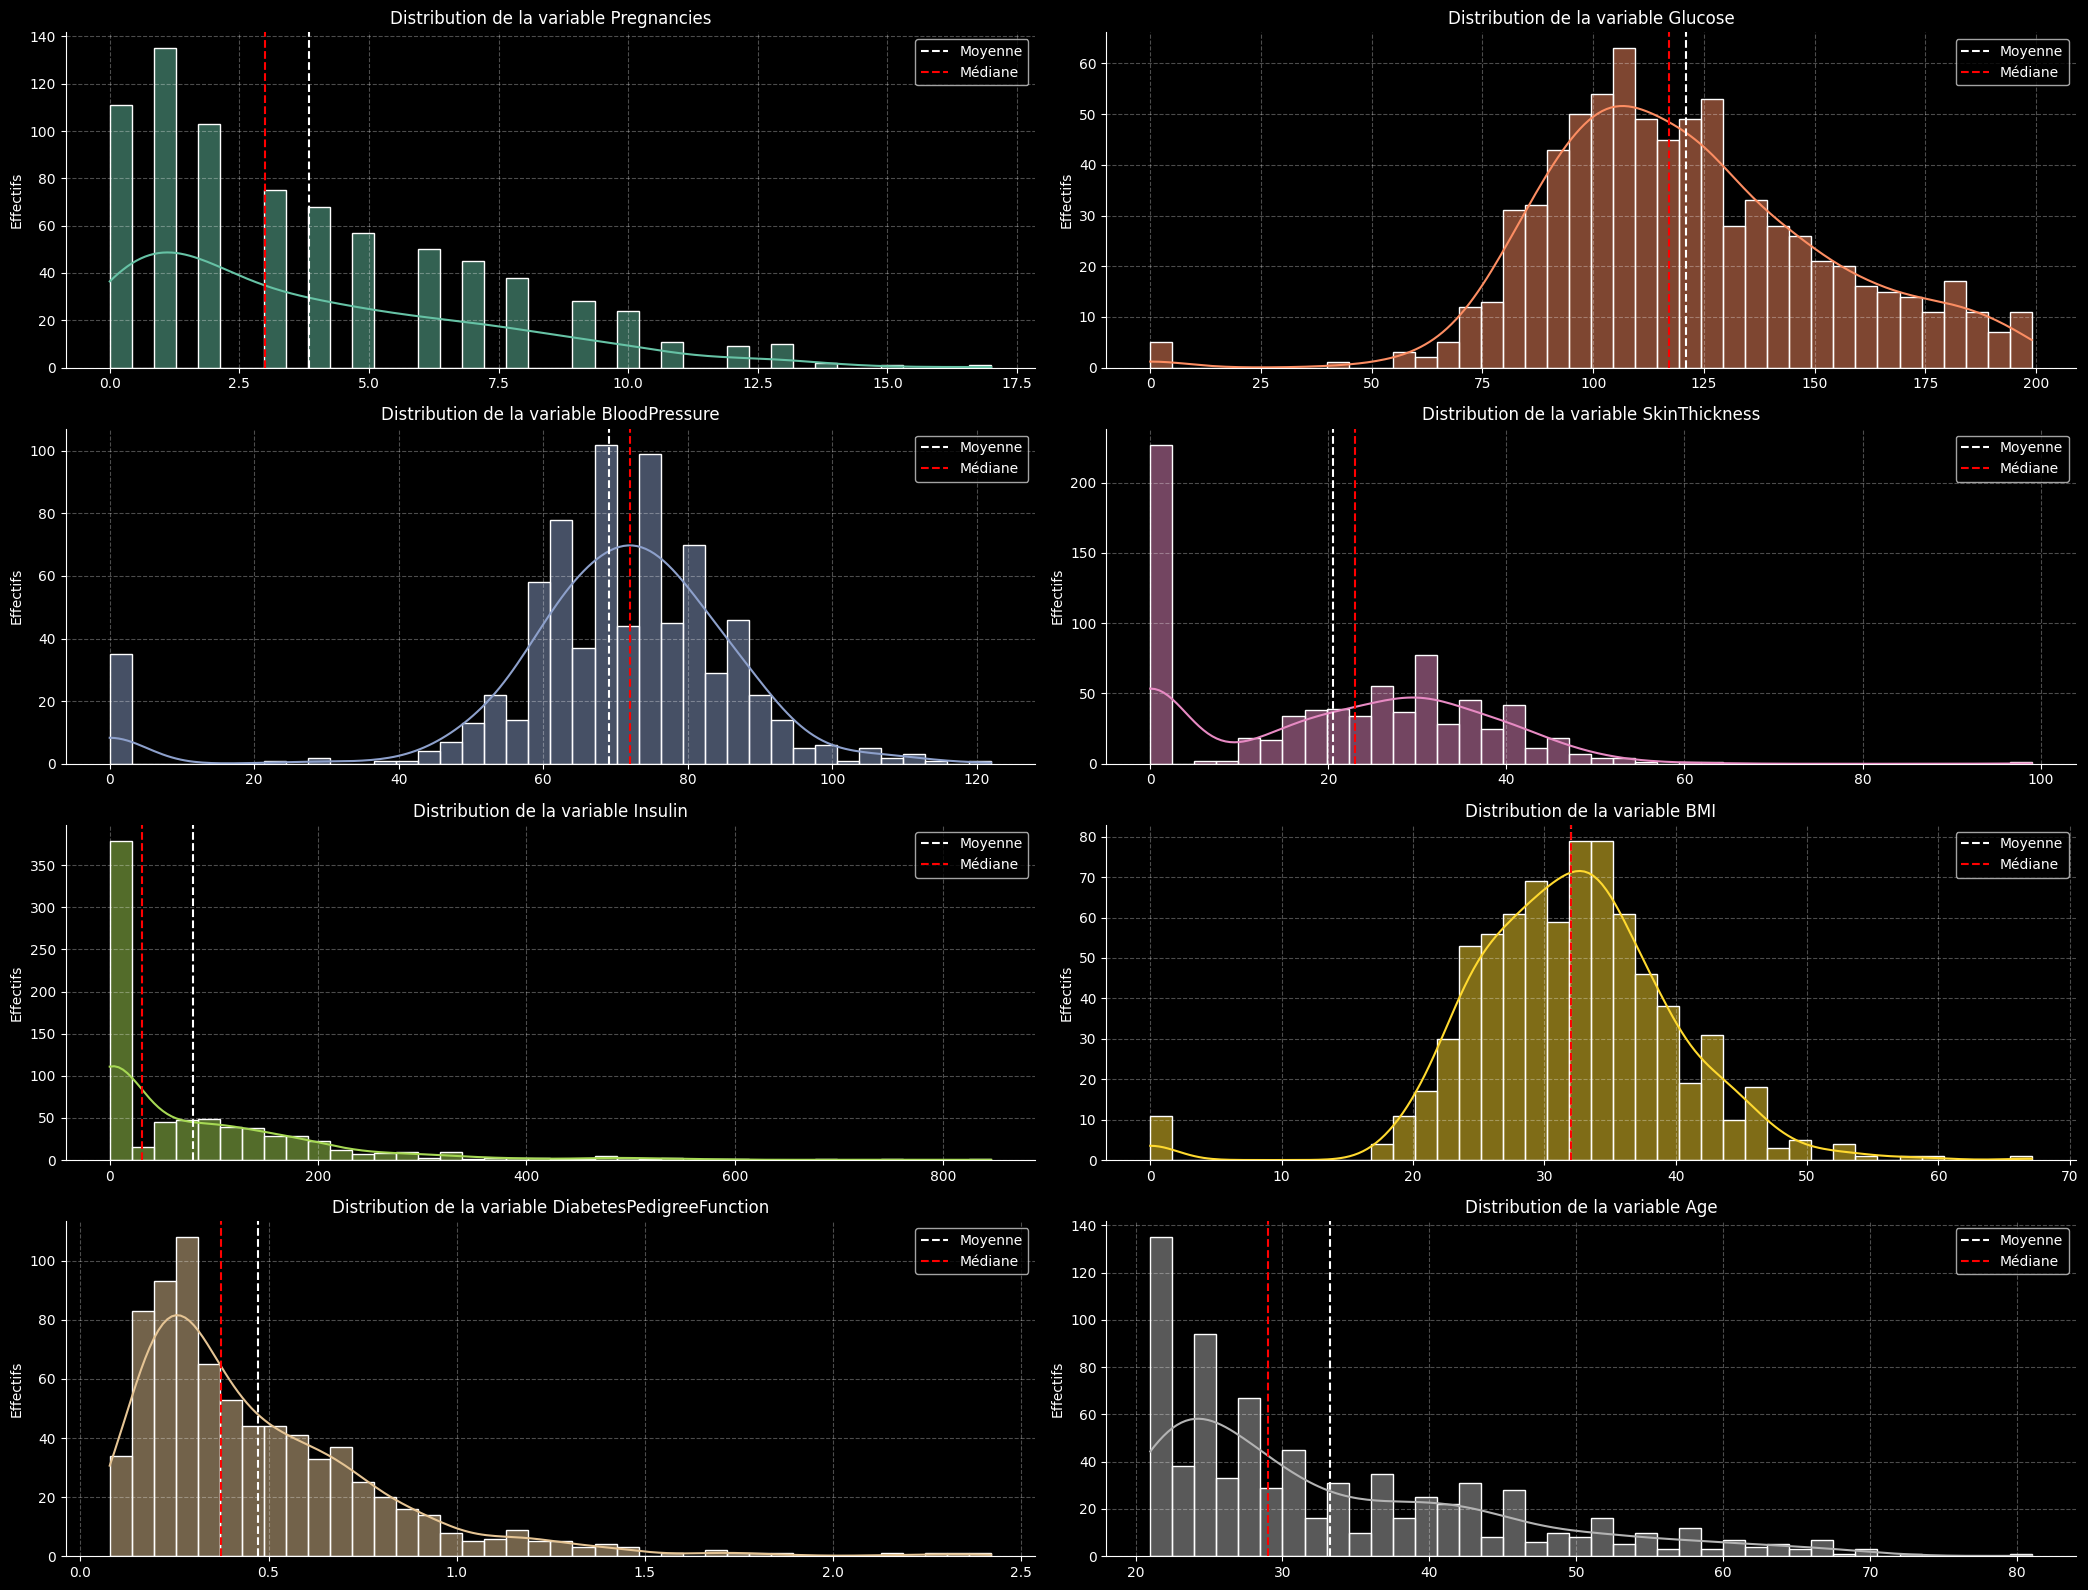

In [13]:
plt.style.use("dark_background")

fig , ax = plt.subplots(nrows=4, ncols=2, figsize=(21,16))
colors = sns.color_palette("Set2", n_colors=8)
axes = ax.ravel()

for i, col in enumerate(df.columns[:-1]):
    sns.histplot(data=df, x=col, ax=axes[i], kde=True, bins=40, color=colors[i])
    mean = df[col].mean()
    median = df[col].median()

    # titres et labels
    axes[i].set_title(f"Distribution de la variable {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Effectifs")

    # moyenne et median
    axes[i].axvline(mean, color="white", linestyle="--", label="Moyenne")
    axes[i].axvline(median, color="red", linestyle="--", label="Médiane")
    axes[i].legend()

    # grilles
    axes[i].xaxis.grid(True, ls="--", alpha=0.3)
    axes[i].yaxis.grid(True, ls="--", alpha=0.3)

    # suppression uniquement des bordures haut et droite
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)

fig.tight_layout()
plt.show()


In [14]:
# plt.style.use("dark_background")

# fig , ax = plt.subplots(nrows=4, ncols=2, figsize=(21,16))
# colors = sns.color_palette("Set2", n_colors=8)
# axes = ax.ravel()
# cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
# df_mis = df.copy()
# df_mis[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)


# for i, col in enumerate(df_mis.columns[:-1]):
#     sns.histplot(data=df_mis, x=col, ax=axes[i], kde=True, bins=40, color=colors[i])
#     mean = df[col].mean()
#     median = df[col].median()

#     # titres et labels
#     axes[i].set_title(f"Distribution de la variable {col}")
#     axes[i].set_xlabel("")
#     axes[i].set_ylabel("Effectifs")

#     # moyenne et median
#     axes[i].axvline(mean, color="white", linestyle="--", label="Moyenne")
#     axes[i].axvline(median, color="red", linestyle="--", label="Médiane")
#     axes[i].legend()

#     # grilles
#     axes[i].xaxis.grid(True, ls="--", alpha=0.3)
#     axes[i].yaxis.grid(True, ls="--", alpha=0.3)

#     # suppression uniquement des bordures haut et droite
#     axes[i].spines["top"].set_visible(False)
#     axes[i].spines["right"].set_visible(False)

# fig.tight_layout()
# plt.show()


### Interprétation des Distributions

Les graphiques de distribution révèlent plusieurs points clés concernant les variables du jeu de données :

*   **Asymétrie :** Plusieurs variables (Pregnancies, SkinThickness, Insulin, DiabetesPedigreeFunction et Age) présentent une asymétrie marquée vers la droite (longue traîne à droite). Les variables BMI et BloodPressure semblent plus proches d'une distribution normale, tandis que la variable Glucose montre une légère asymétrie vers la gauche.
* Les variables n'ont pas la même échelle
*   **Valeurs nulles (0) :** Les valeurs de 0 observées dans BloodPressure, SkinThickness, Insulin et BMI sont probablement des valeurs manquantes ou des erreurs, car elles ne sont pas physiologiquement possibles. Ces valeurs devront être traitées lors de la phase de prétraitement des données.


In [15]:
df.groupby("Outcome").agg(["mean", "median"])

Pregnancies            Glucose        BloodPressure         \
               mean median        mean median          mean median   
Outcome                                                              
0          3.298000    2.0  109.980000  107.0     68.184000   70.0   
1          4.865672    4.0  141.257463  140.0     70.824627   74.0   

        SkinThickness            Insulin               BMI         \
                 mean median        mean median       mean median   
Outcome                                                             
0           19.664000   21.0   68.792000   39.0  30.304200  30.05   
1           22.164179   27.0  100.335821    0.0  35.142537  34.25   

        DiabetesPedigreeFunction               Age         
                            mean median       mean median  
Outcome                                                    
0                       0.429734  0.336  31.190000   27.0  
1                       0.550500  0.449  37.067164   36.0

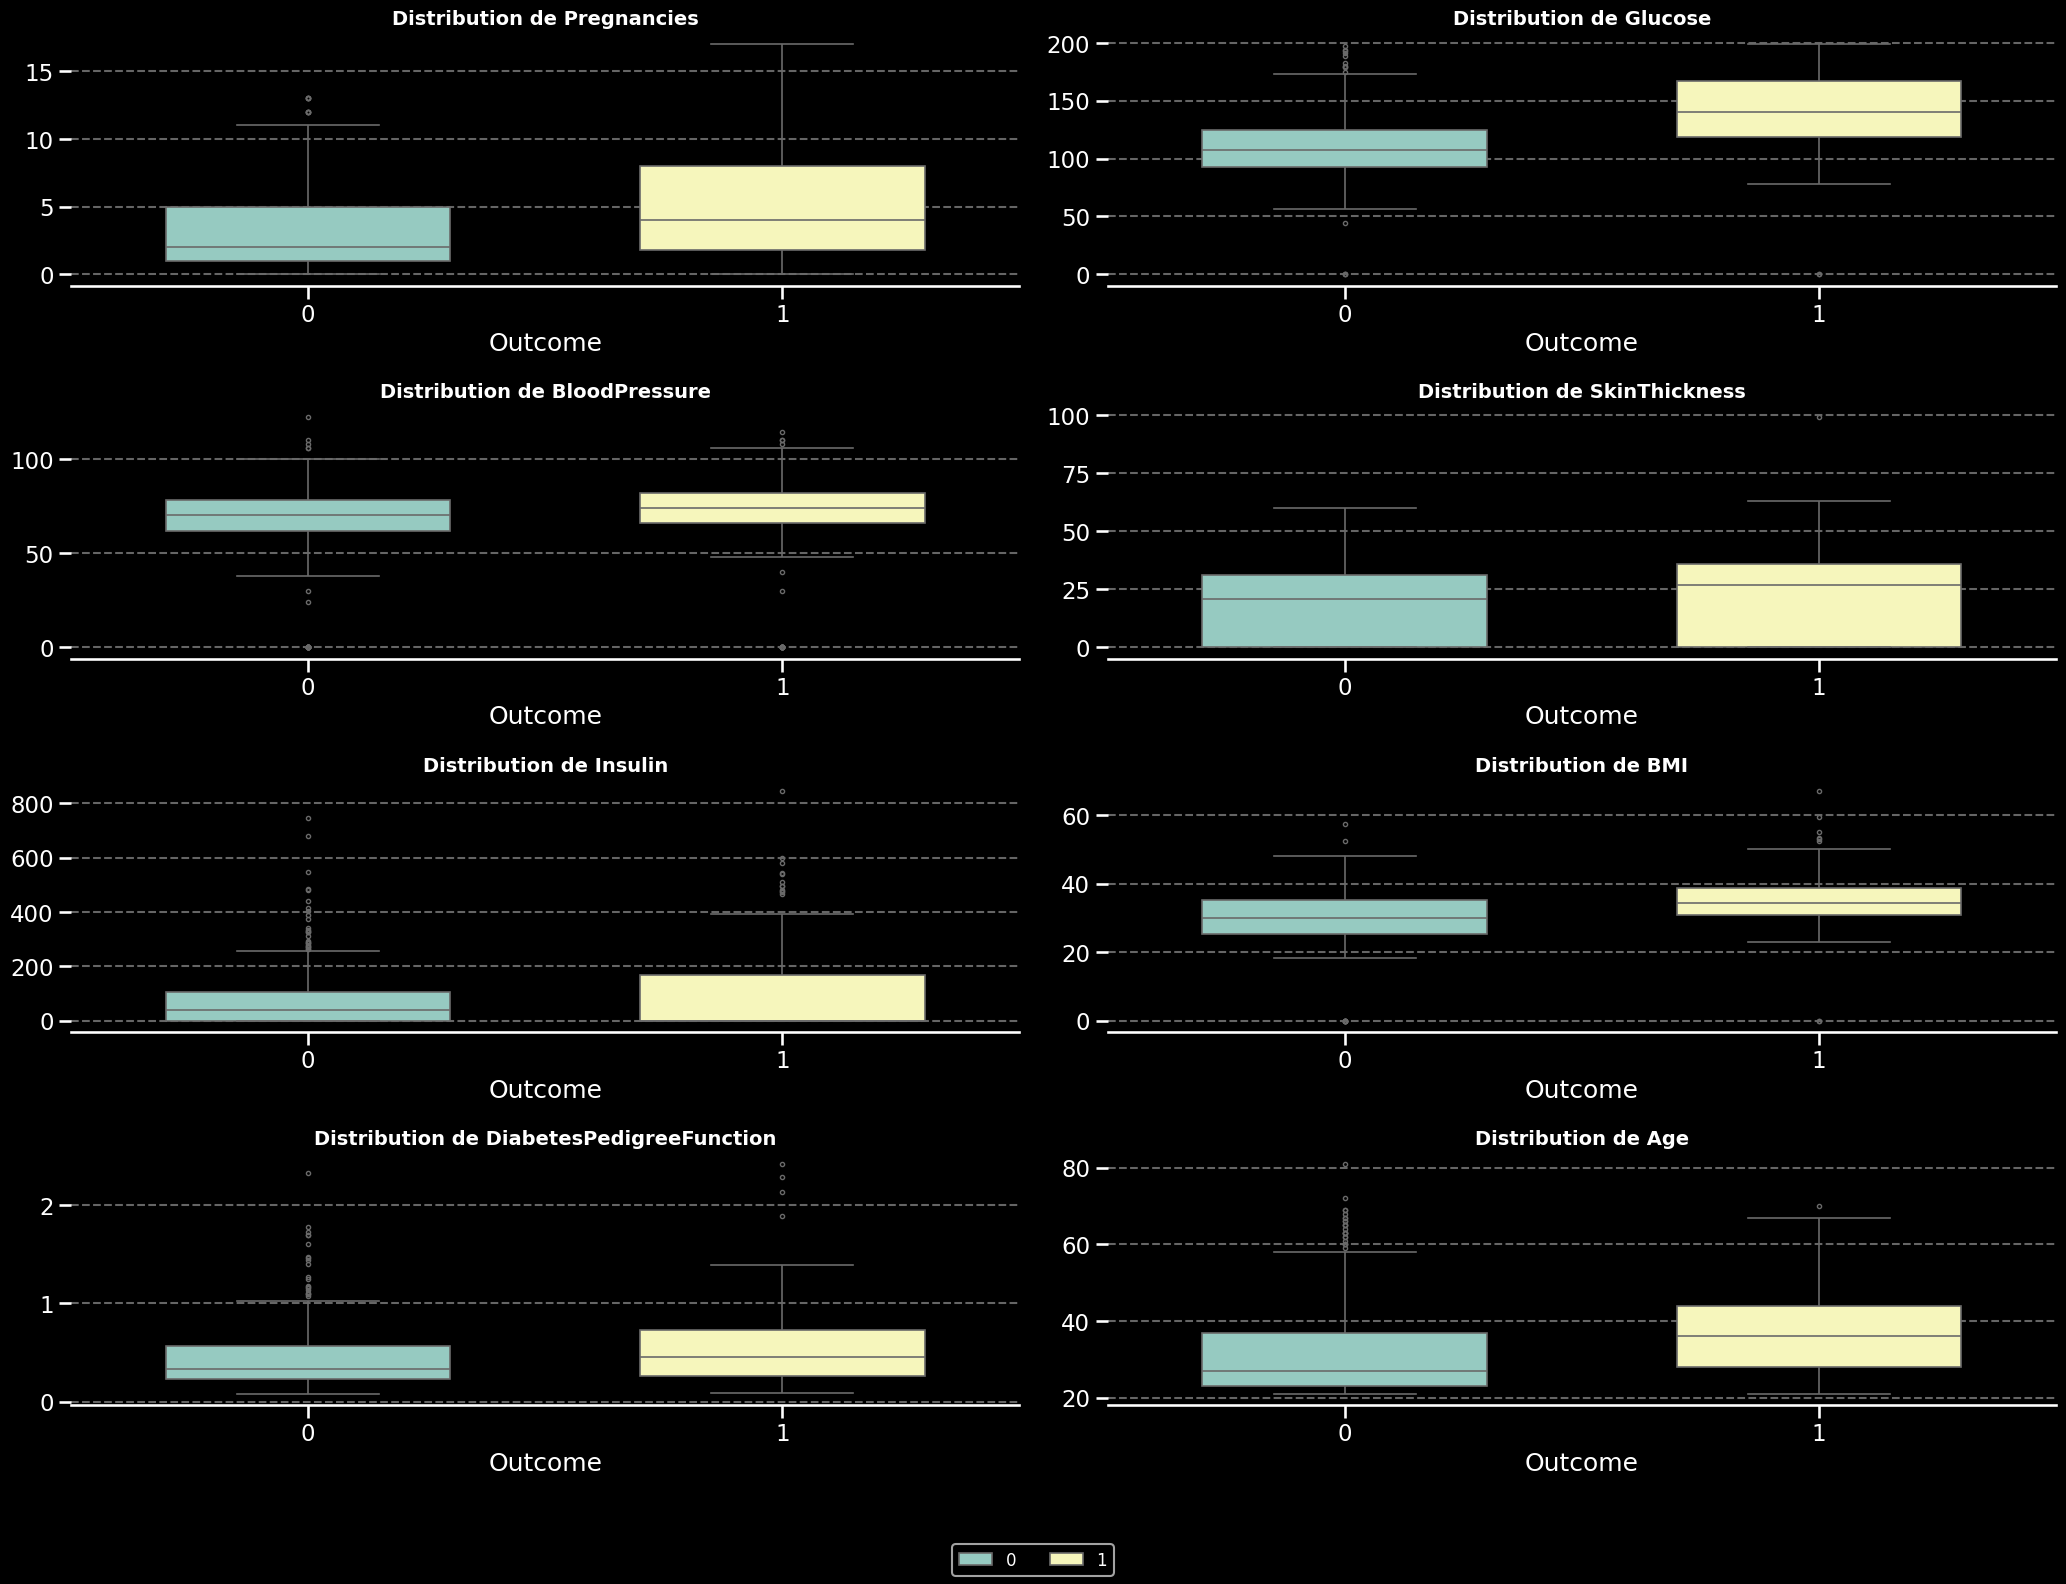

In [16]:
plt.style.use("dark_background")
sns.set_context("talk")

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(21,16))
axes = ax.ravel()

for i, col in enumerate(df.columns[:-1]):
    sns.boxplot(data=df, y=col, x="Outcome", ax=axes[i], hue="Outcome",
                palette="Set3", width=0.6, fliersize=3, linewidth=1.2)

    # titre et labels
    axes[i].set_title(f"Distribution de {col}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Outcome")
    axes[i].set_ylabel("")
    axes[i].legend().set_visible(False)

    # suppression bordures superflues
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["left"].set_visible(False)
    axes[i].spines["right"].set_visible(False)

    # grilles légères pour aider à lire
    axes[i].yaxis.grid(True, ls="--", alpha=0.4)

# légende globale (placée en bas)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", fontsize=12, ncol=2)

fig.tight_layout(rect=[0, 0.05, 1, 1])  # laisse de la place pour la légende en bas
plt.show()


### Interprétation des Box Plots

Les box plots nous permettent de comparer la distribution de chaque variable explicative entre les deux groupes de la variable cible (Outcome : 0 pour non diabétique, 1 pour diabétique). Voici les observations clés :

*   **Pregnancies :** Le nombre de grossesses est généralement plus élevé chez les femmes diabétiques (Outcome=1) comparé aux non diabétiques (Outcome=0).
*   **Glucose :** Il existe une différence significative dans les niveaux de glucose entre les deux groupes. Les femmes diabétiques ont des niveaux de glucose nettement plus élevés.
*   **BloodPressure :** La pression artérielle est légèrement plus élevée chez les femmes diabétiques, mais le chevauchement des boîtes suggère que cette variable est moins discriminante seule.
*   **SkinThickness :** L'épaisseur de la peau montre une légère tendance à être plus élevée chez les diabétiques, mais avec un chevauchement important entre les groupes.
*   **Insulin :** Les niveaux d'insuline sont considérablement plus élevés chez les femmes diabétiques. La présence de nombreuses valeurs nulles dans le groupe non diabétique est également visible.
*   **BMI :** L'indice de masse corporelle est clairement plus élevé chez les femmes diabétiques.
*   **DiabetesPedigreeFunction :** Cette fonction montre des valeurs plus élevées chez les femmes diabétiques, indiquant un risque accru basé sur les antécédents familiaux.
*   **Age :** Les femmes diabétiques sont en moyenne plus âgées que les femmes non diabétiques.

En conclusion, les variables Glucose, BMI et Age semblent être les plus discriminantes pour différencier les femmes diabétiques des non diabétiques. Les box plots confirment également la présence de valeurs nulles et d'outliers qui nécessiteront un traitement.

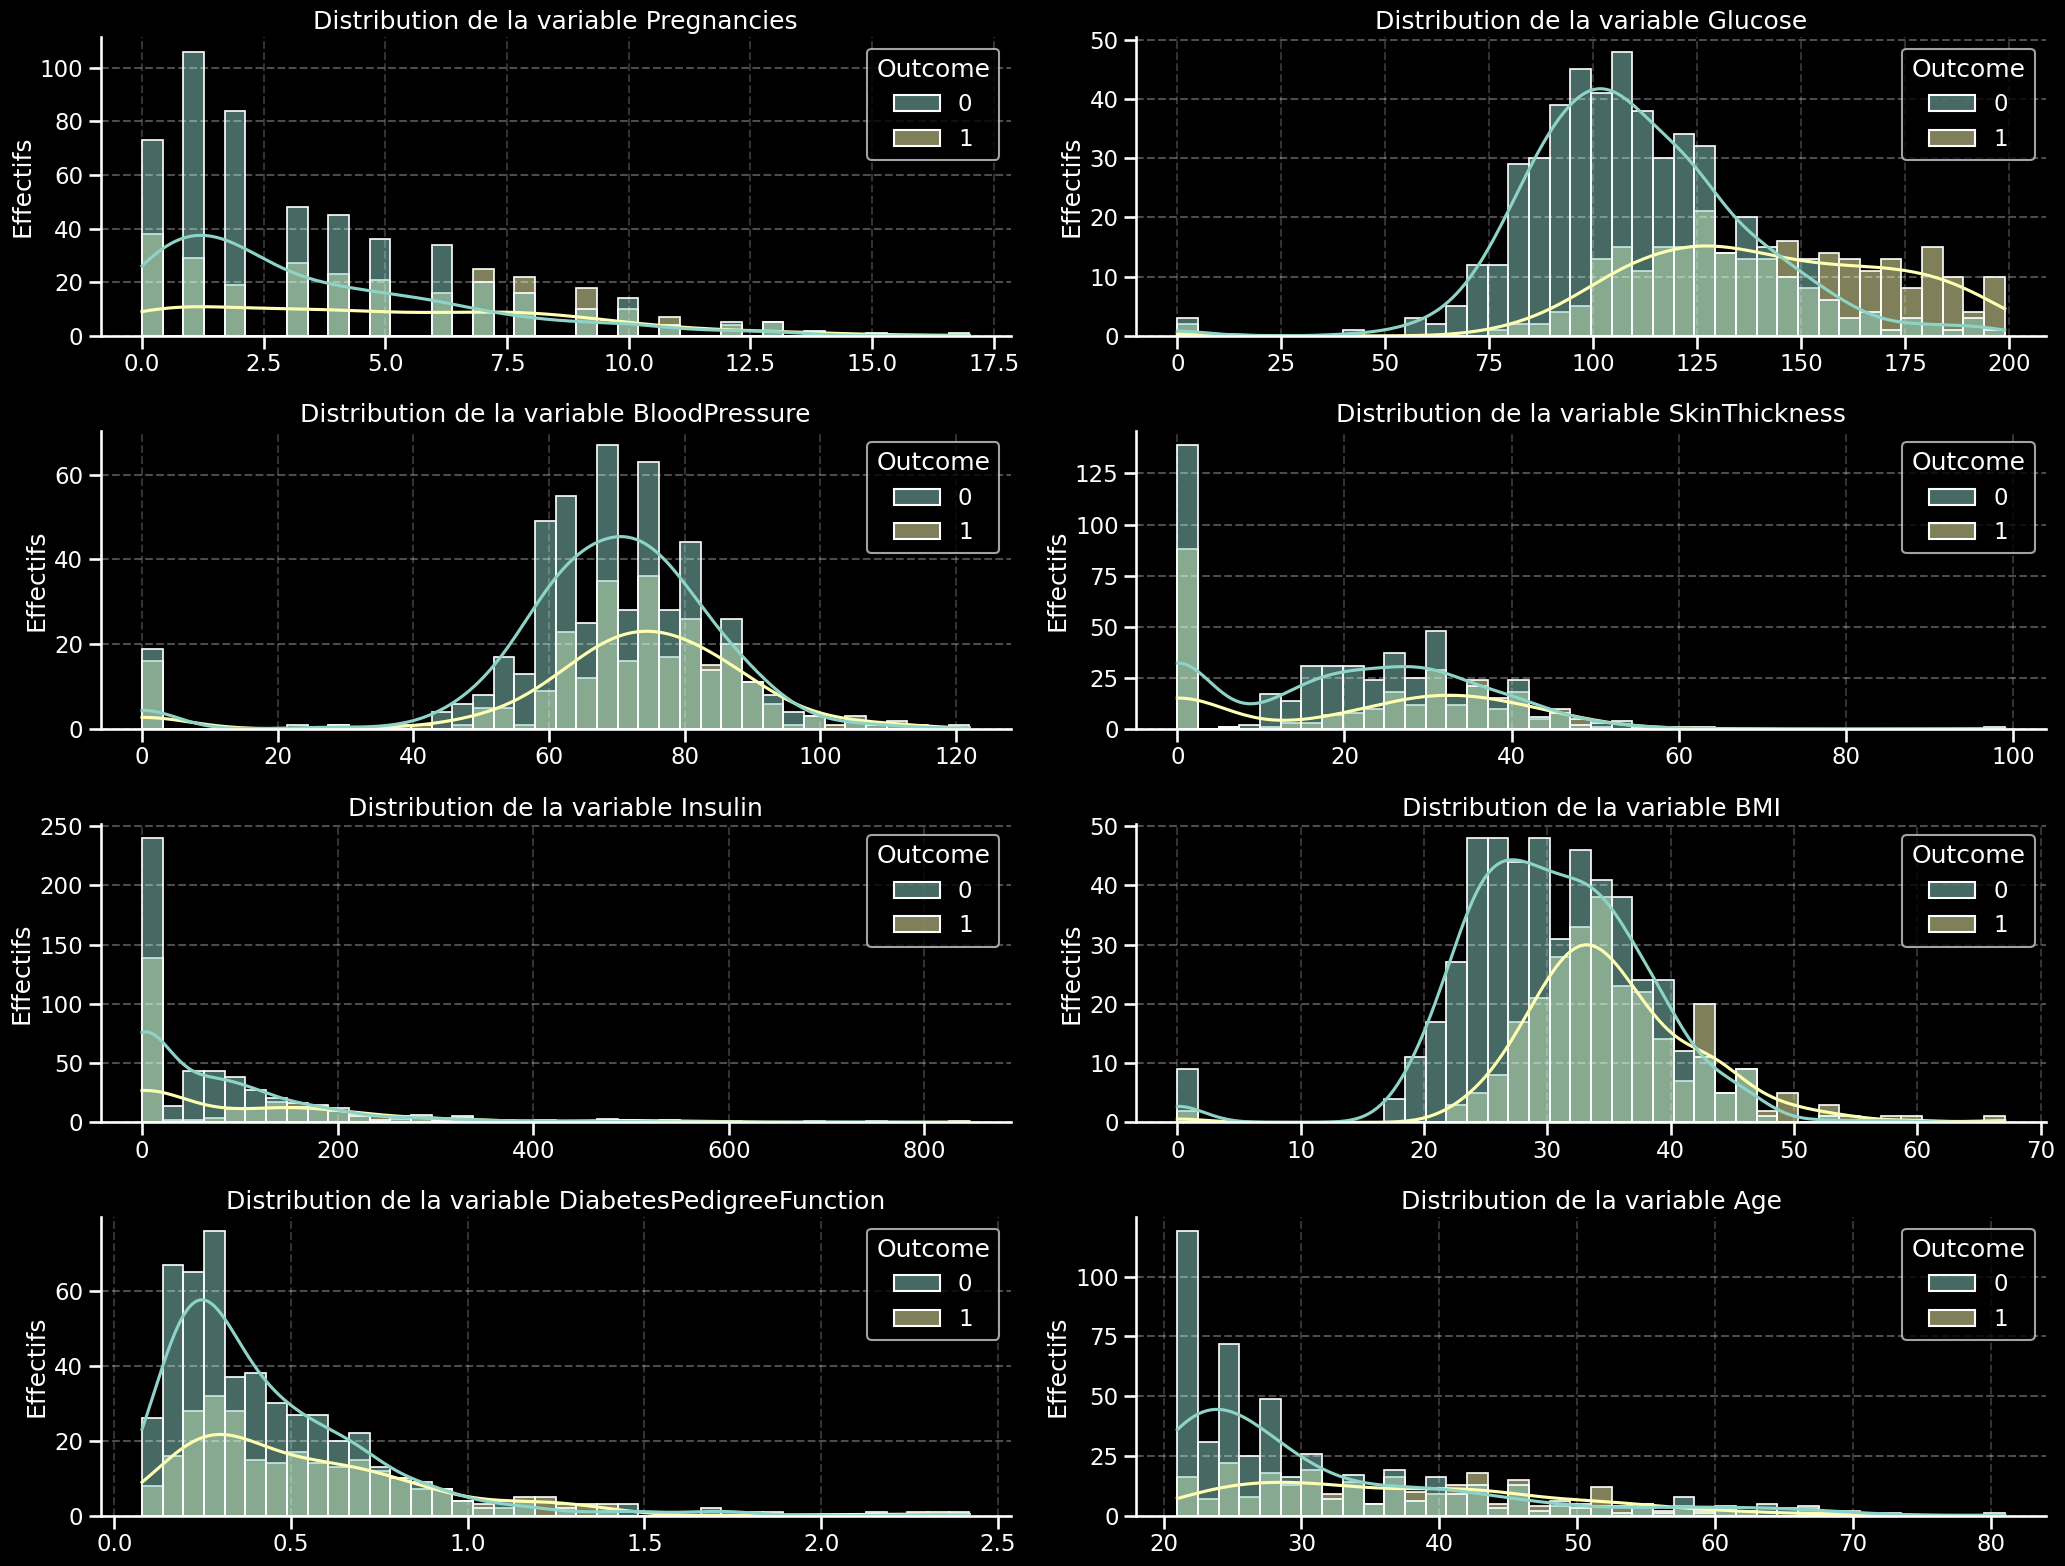

In [17]:
plt.style.use("dark_background")

fig , ax = plt.subplots(nrows=4, ncols=2, figsize=(21,16))
colors = sns.color_palette("Set2", n_colors=8)
axes = ax.ravel()

for i, col in enumerate(df.columns[:-1]):
    sns.histplot(data=df, x=col, ax=axes[i], kde=True, bins=40, color=colors[i],hue="Outcome")

    # titres et labels
    axes[i].set_title(f"Distribution de la variable {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Effectifs")

    # grilles
    axes[i].xaxis.grid(True, ls="--", alpha=0.2)
    axes[i].yaxis.grid(True, ls="--", alpha=0.3)

    # suppression uniquement des bordures haut et droite
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)

fig.tight_layout()
plt.show()


### Interprétation des Distributions en fonction de la variabe cible ( Outcome )

Ce graphique montre les distributions de chaque variable explicative (sauf la variable cible) séparées en fonction de la variable "Outcome" (0 pour non diabétique, 1 pour diabétique) à l'aide d'histogrammes et de courbes de densité (KDE). Cela nous permet de comparer visuellement les caractéristiques de chaque variable entre les deux groupes.

Voici une synthèse des observations :

*   **Variables avec une bonne séparation :** Les distributions de **Glucose**, **BMI** (Indice de Masse Corporelle) et **Age** montrent une séparation notable entre les groupes non diabétique et diabétique. Les femmes diabétiques ont tendance à avoir des valeurs plus élevées pour ces trois variables, ce qui suggère qu'elles sont de bons indicateurs potentiels de diabète.
*   **Variables avec un chevauchement important :** Les distributions de **BloodPressure** (Pression Artérielle), **SkinThickness** (Épaisseur de la peau) et **DiabetesPedigreeFunction** montrent un chevauchement plus important entre les deux groupes. Bien qu'il y ait des tendances (légèrement plus élevées chez les diabétiques), ces variables seules sont moins discriminantes.
*   **Variables avec des valeurs nulles importantes :** Les histogrammes de **BloodPressure**, **SkinThickness**, **Insulin** et **BMI** confirment la présence de nombreuses valeurs égales à 0. Ces zéros sont particulièrement concentrés dans le groupe non diabétique pour l'Insulin et le SkinThickness, et présents dans les deux groupes pour BloodPressure et BMI (Observés précédemment).
*   **Pregnancies :** La distribution des grossesses est légèrement décalée vers la droite pour le groupe diabétique, indiquant un nombre de grossesses plus élevé en moyenne.
*   **Insulin :** Au-delà des valeurs de 0, la distribution de l'insuline est plus étendue vers des valeurs élevées chez les femmes diabétiques, bien qu'avec un chevauchement important.

Ce graphique renforce l'idée que le Glucose, le BMI et l'Age sont les prédicteurs les plus prometteurs. Il met également en évidence le problème des valeurs nulles (probablement manquantes) dans plusieurs variables, ce qui sera une étape cruciale du prétraitement des données.

## Matrice de corrélations

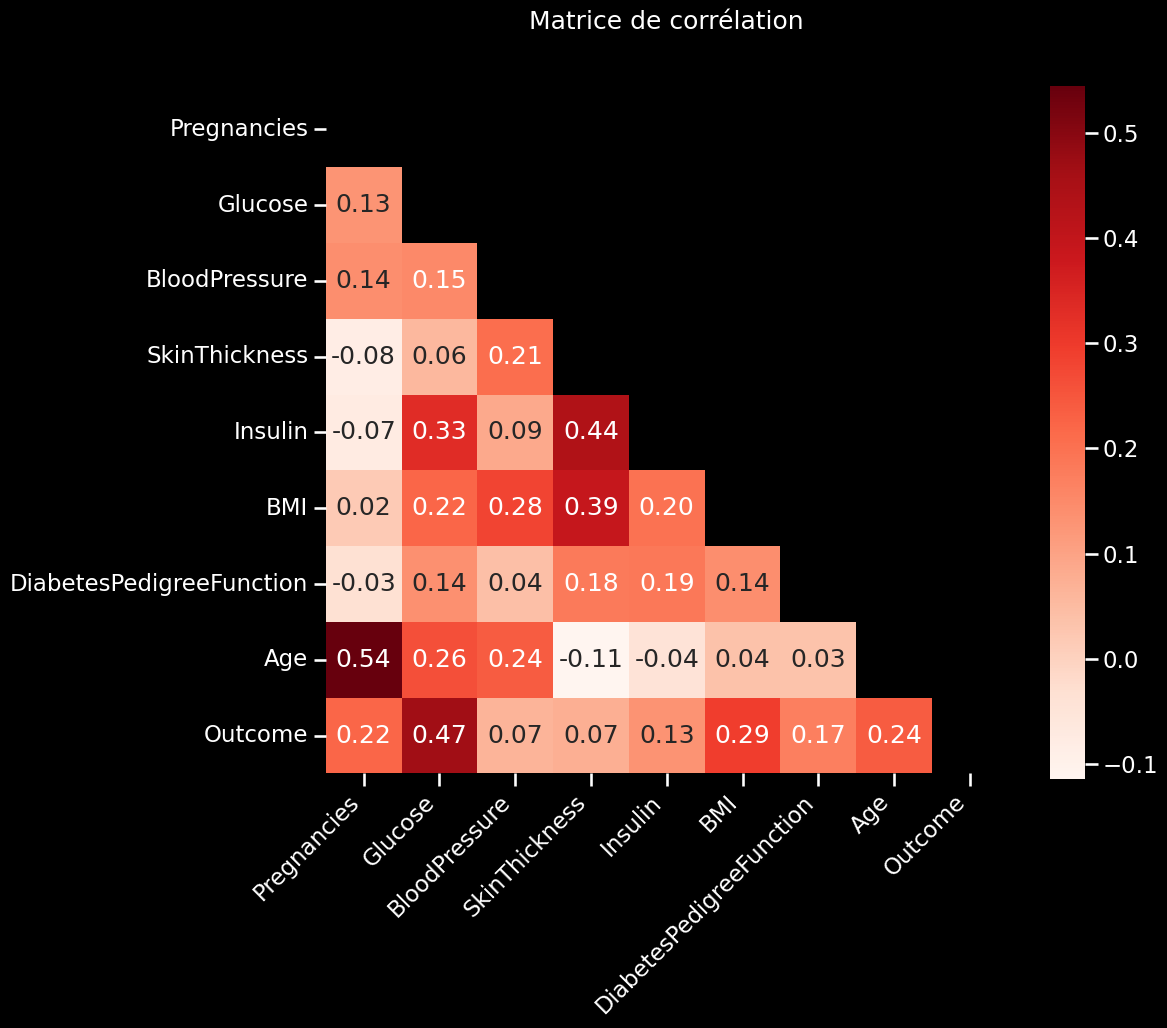

In [18]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap='Reds', annot=True, fmt=".2f",
            square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Matrice de corrélation",pad=45)

# cbar = ax.collections[0].colorbar
# cbar.ax.set_position([0.35, 0.30, 0.3, 0.6])  # [x, y, largeur, hauteur]
plt.show()

### Interprétation de la Matrice de Corrélation

La matrice de corrélation de Pearson montre les relations linéaires entre chaque paire de variables. Les valeurs vont de -1 (corrélation négative parfaite) à 1 (corrélation positive parfaite), avec 0 indiquant l'absence de corrélation linéaire.

Points clés :

*   **Corrélations avec la variable cible (Outcome) :**
    *   `Glucose` (0.47) présente la corrélation positive la plus forte avec l'Outcome. Un niveau de glucose élevé est un indicateur clé de diabète.
    *   `BMI` (0.29) et `Age` (0.24) montrent des corrélations positives modérées avec l'Outcome.
    *   `Pregnancies` (0.22) et `DiabetesPedigreeFunction` (0.17) ont des corrélations positives plus faibles.
    *   `Insulin` (0.13), `BloodPressure` (0.07) et `SkinThickness` (0.07) ont de très faibles corrélations avec l'Outcome, suggérant qu'elles sont moins directement liées au diagnostic de diabète dans ce jeu de données.

*   **Corrélations entre variables explicatives :**
    *   `Pregnancies` et `Age` sont modérément corrélées (0.54), ce qui est attendu.
    *   `SkinThickness` et `Insulin` montrent une corrélation modérée à forte (0.44).
    *   `BMI` est modérément corrélé avec `SkinThickness` (0.39) et `Glucose` (0.22).
    *   `Glucose` est également modérément corrélé avec `Insulin` (0.33).

Cette analyse de corrélation renforce l'idée que `Glucose`, `BMI` et `Age` sont les prédicteurs les plus pertinents pour la modélisation. Elle met également en évidence des interdépendances entre certaines variables explicatives qu'il faudra considérer lors du choix et de l'ajustement du modèle.

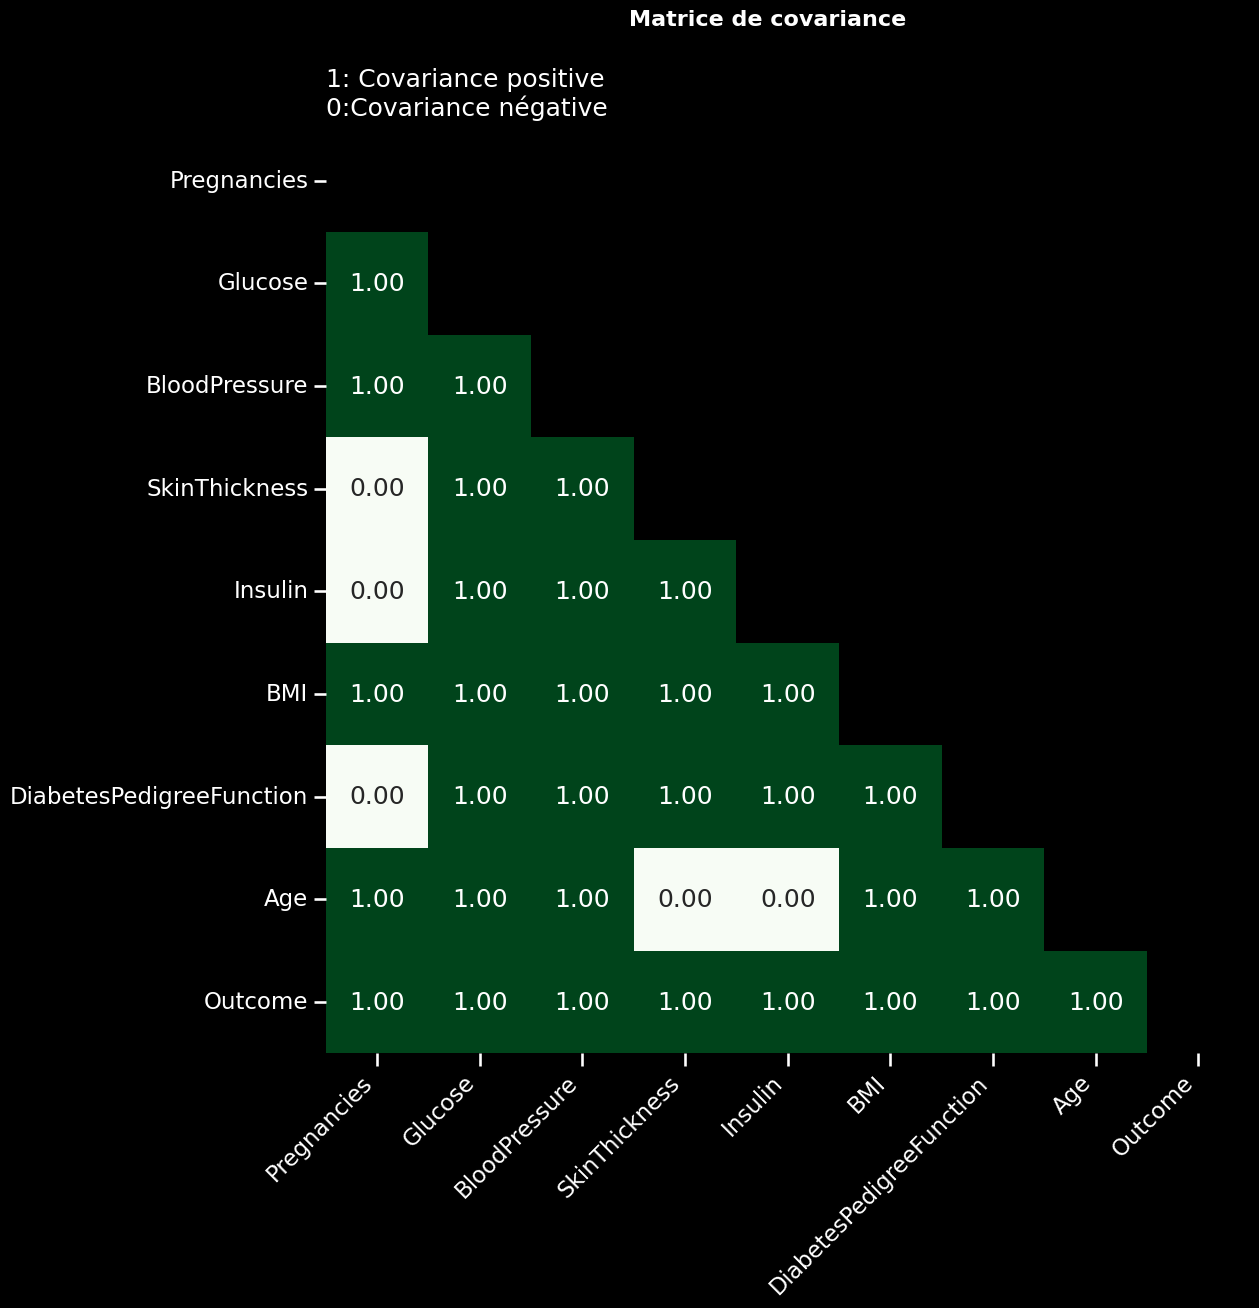

In [19]:


# Matrice de covariance
cov = df.cov()
cov = (cov > 0 ).replace({True: 1, False: 0})

# Masque triangulaire
mask = np.triu(np.ones_like(cov, dtype=bool))

# Heatmap
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(
    cov, mask=mask, cmap="Greens", annot=True, fmt=".2f",
    square=True, cbar = False
)

# Rotation et titre
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("1: Covariance positive \n0:Covariance négative", pad=10,loc="left")
f.suptitle("Matrice de covariance", fontsize=16, fontweight="bold")

plt.show()


In [20]:
# (cov > 0).replace({True: "+", False: "-"})

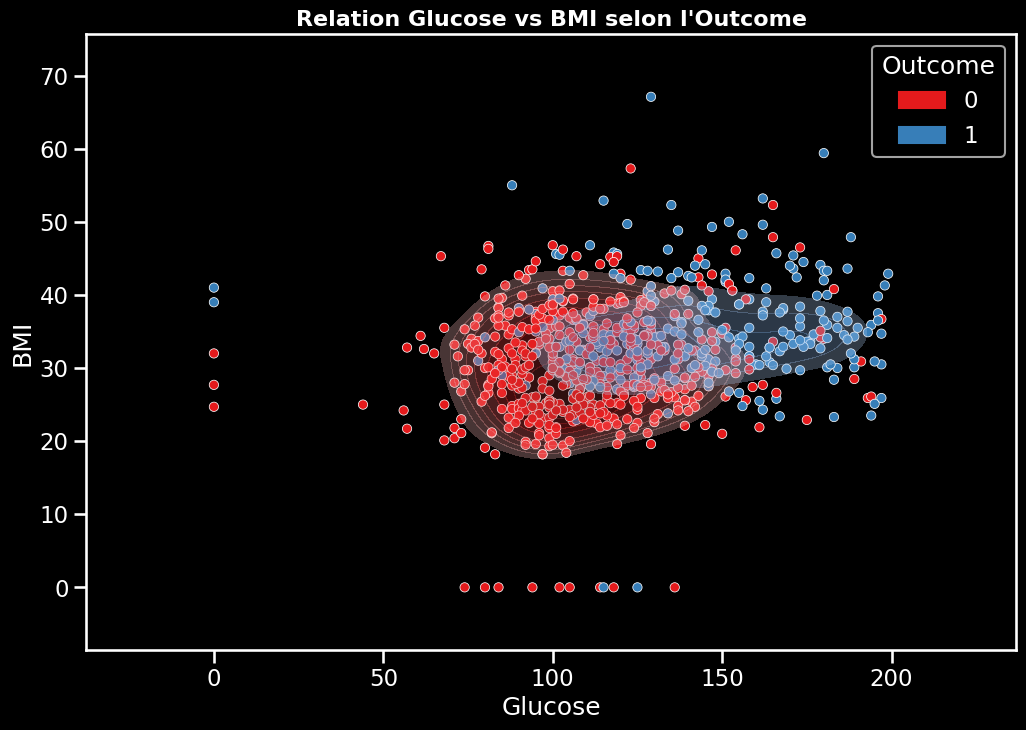

In [21]:
f, ax = plt.subplots(figsize=(12, 8))
s=df["Glucose"]/df["BMI"]
# Scatter
sns.scatterplot(
    data=df,
    x="Glucose", y="BMI", hue="Outcome", ax=ax,s=45 , palette="Set1"
)

# KDE 2D par catégorie
sns.kdeplot(
    data=df,
    x="Glucose", y="BMI", hue="Outcome",palette="Set1",
    fill=True, thresh=0.3, alpha=0.3, ax=ax
)

# Titre & style
ax.set_title("Relation Glucose vs BMI selon l'Outcome", fontsize=16, weight="bold")
plt.show()


### Interprétation de la Relation Glucose vs BMI selon l'Outcome

Ce graphique combine un nuage de points (scatterplot) et des estimations de densité de noyau (KDE - Kernel Density Estimate) pour visualiser la relation entre le Glucose et le BMI, différenciée par la variable cible "Outcome" (0 pour non diabétique, 1 pour diabétique).

Points clés :

* **Séparation des Groupes :** Le graphique montre une séparation claire entre les groupes non diabétique (rouge) et diabétique (bleu) en fonction des valeurs de Glucose et de BMI. Les femmes diabétiques (Outcome=1) ont tendance à se situer dans la partie supérieure droite du graphique, avec des niveaux de Glucose et des valeurs de BMI plus élevés. Les femmes non diabétiques (Outcome=0) sont plus concentrées dans la partie inférieure gauche.
* **Densités :** Les zones de densité (représentées par les contours) confirment cette séparation. La densité des femmes diabétiques est concentrée autour de valeurs de Glucose et de BMI plus élevées que celle des femmes non diabétiques. Il y a un certain chevauchement entre les deux densités, en particulier dans la zone où les valeurs de Glucose et de BMI sont intermédiaires, ce qui est attendu dans un problème de classification.
* **Outliers :** Les points individuels (scatterplot) mettent en évidence la distribution réelle des données et la présence de quelques valeurs extrêmes (outliers), notamment pour les femmes diabétiques qui peuvent avoir des valeurs de Glucose très élevées. Les valeurs nulles (0) pour le Glucose et le BMI, mentionnées précédemment, sont également visibles sur le graphique.
* **Interaction des Variables :** Le graphique suggère que ni le Glucose ni le BMI seuls ne sont des prédicteurs parfaits, mais leur combinaison est beaucoup plus discriminante. Une patiente avec un Glucose élevé *et* un BMI élevé a une probabilité plus élevée d'être diabétique.

En résumé, ce graphique confirme visuellement que le Glucose et le BMI sont des variables importantes pour prédire le diabète et qu'elles ont un effet combiné significatif. Il souligne également la nécessité de traiter les valeurs nulles identifiées dans ces variables.

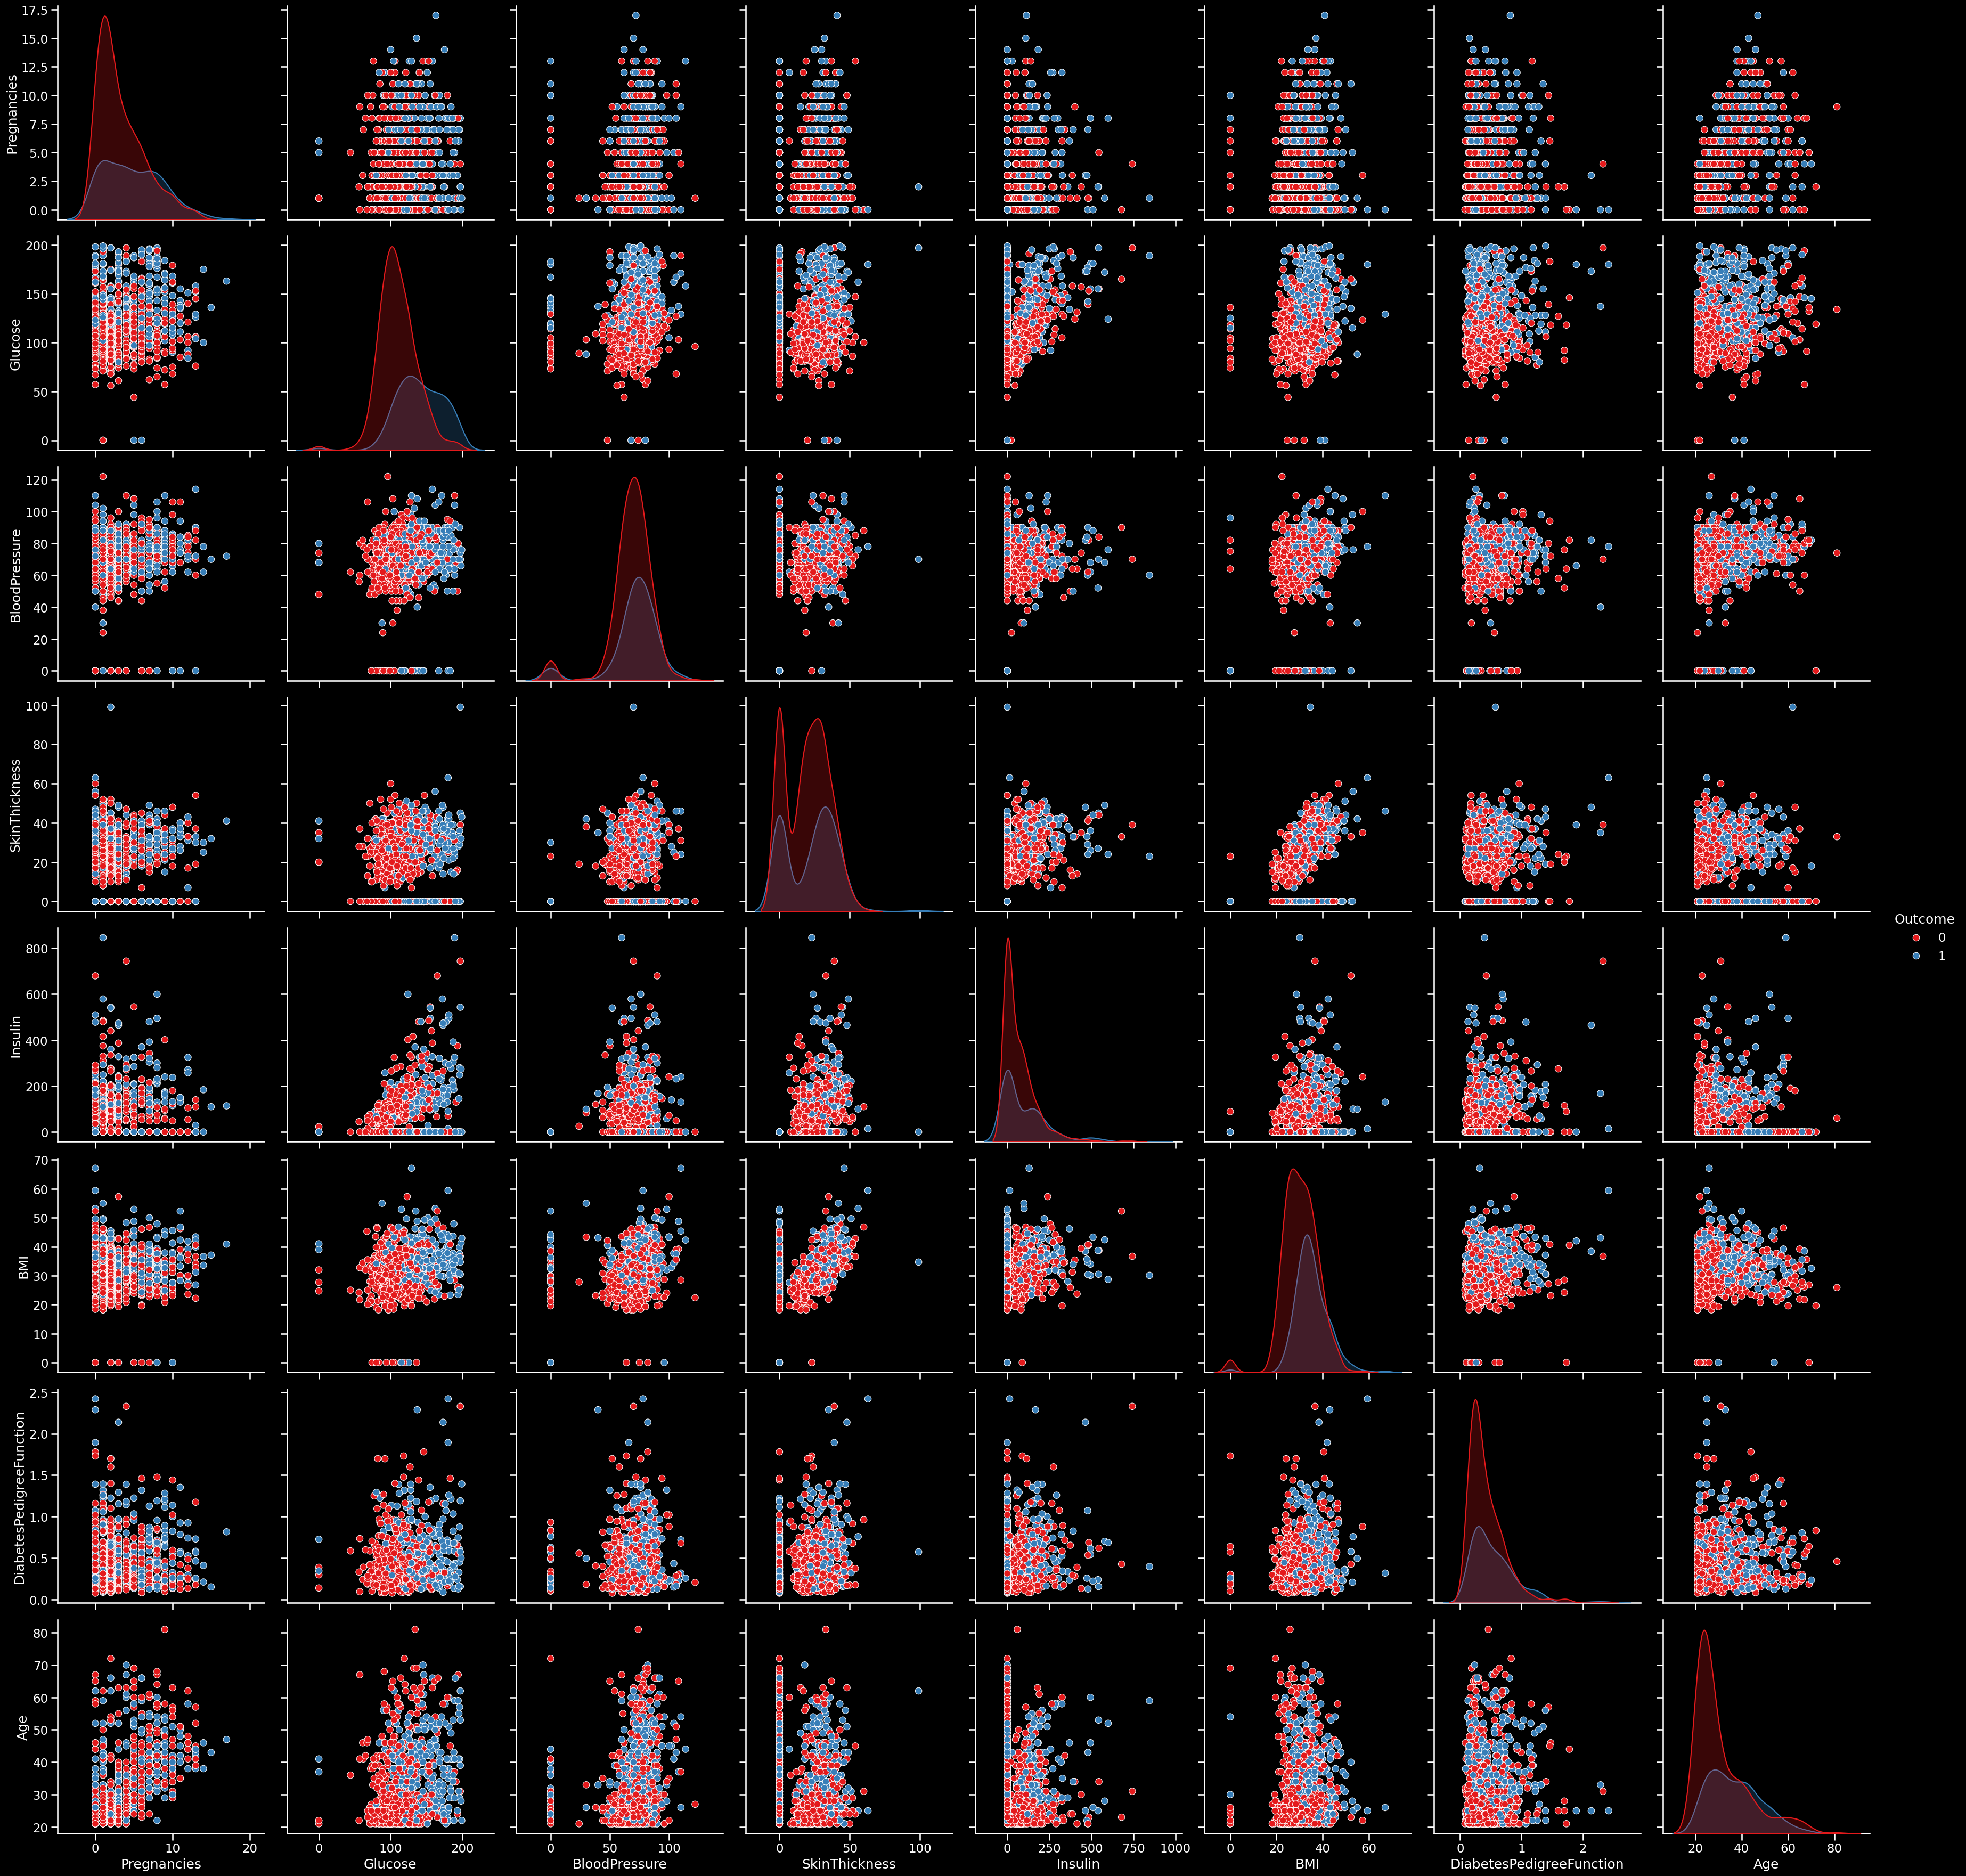

In [22]:
sns.pairplot(df,hue="Outcome",height=4.5,aspect=1,palette="Set1")

Now let's visualize the distribution of this new risk variable based on the outcome.

**Variables montrant une bonne séparation entre les classes :**

*   **Glucose :** Sur les histogrammes diagonaux, la distribution du Glucose pour le groupe diabétique (orange) est clairement décalée vers des valeurs plus élevées par rapport au groupe non diabétique (bleu). Sur les nuages de points, on observe une concentration de points orange (diabétiques) à des valeurs de Glucose plus élevées, quelle que soit l'autre variable. C'est l'un des prédicteurs les plus discriminants.
*   **BMI (Indice de Masse Corporelle) :** Similairement au Glucose, la distribution du BMI est plus élevée pour le groupe diabétique. Le nuage de points `BMI` vs. toute autre variable montre une tendance des points orange à se situer dans les zones de BMI plus élevés.
*   **Age :** La distribution de l'âge est également décalée vers des âges plus avancés pour les patients diabétiques. L'âge semble particulièrement discriminant en combinaison avec d'autres variables comme le Glucose.

**Variables qui se chevauchent fortement (pas très discriminantes seules) :**

*   **BloodPressure (Pression Artérielle) :** Les distributions de la pression artérielle se chevauchent considérablement entre les deux groupes. Bien qu'il y ait une légère tendance à des valeurs plus élevées chez les diabétiques, cette variable seule n'offre pas une grande capacité de séparation.
*   **SkinThickness (Épaisseur de la peau) :** L'épaisseur de la peau montre également un fort chevauchement. On observe beaucoup de valeurs de 0, en particulier chez les non diabétiques, ce qui complique l'interprétation directe de sa distribution seule.
*   **Insulin :** Malgré des valeurs d'insuline généralement plus élevées chez les diabétiques (au-delà des zéros), le chevauchement et le grand nombre de valeurs nulles (qui sont probablement des valeurs manquantes) rendent cette variable moins discriminante en l'état.
*   **DiabetesPedigreeFunction :** Bien que légèrement plus élevée en moyenne chez les diabétiques, la distribution de cette variable se chevauche fortement, limitant sa capacité à distinguer clairement les groupes seule.
*   **Pregnancies (Grossesses) :** Le nombre de grossesses est légèrement plus élevé chez les diabétiques, mais il y a un chevauchement important, surtout pour les faibles nombres de grossesses.

**Relations entre variables visibles (corrélations, clusters, tendances) :**

Les nuages de points révèlent des relations intéressantes entre les variables :

*   **Glucose vs. BMI :** Comme vu précédemment avec le scatter plot dédié, cette combinaison est très informative. Les diabétiques se concentrent dans les zones où Glucose et BMI sont élevés.
*   **Age vs. Pregnancies :** Il existe une corrélation positive visible ; les femmes plus âgées ont tendance à avoir eu plus de grossesses.
*   **SkinThickness vs. Insulin :** Ces deux variables montrent une corrélation positive. Les valeurs de 0 sont très apparentes dans ces deux variables, formant des groupes distincts sur les graphiques impliquant SkinThickness et Insulin.
*   **Glucose vs. Insulin :** On observe une corrélation positive, mais avec une grande dispersion due aux valeurs de 0 pour l'insuline.

**Résumé :**

Imaginez que nous observions ces patientes. Les patientes qui ont reçu un diagnostic de diabète (Outcome=1) se distinguent souvent des autres de plusieurs manières. Elles ont, en moyenne, des niveaux de **Glucose** plus élevés, un **Indice de Masse Corporelle (BMI)** plus important, et elles sont souvent plus **âgées**. Lorsque nous regardons les patientes avec un diagnostic de diabète, elles ont tendance à se regrouper dans des zones du graphique où ces trois caractéristiques (Glucose, BMI, Age) atteignent des valeurs plus élevées. Les autres variables comme la Pression Artérielle, l'épaisseur de la peau ou même l'insuline (à cause des nombreuses valeurs "zéro" qui masquent la vraie distribution) sont moins claires pour séparer les deux groupes par elles-mêmes. Cependant, des combinaisons comme un **Glucose élevé associé à un BMI élevé** sont particulièrement révélatrices et montrent clairement où se situent la plupart des patientes diabétiques. Le pairplot nous raconte l'histoire que le diabète dans cet échantillon est fortement associé à des marqueurs métaboliques (Glucose, BMI) et à l'âge.

# Préparer les données pour les algorithmes d'apprentissage automatique

Nos données présentent de nombreuses valeurs aberrantes ou manquantes : environ 49 % des observations contiennent au moins une information physiologiquement impossible (zéros pour certaines variables comme Glucose, BloodPressure, SkinThickness, Insulin ou BMI).
Pour corriger cela, la première étape consiste à remplacer ces zéros par des valeurs manquantes (NaN), ce qui permet ensuite d’appliquer des stratégies d’imputation adaptées à chaque variable afin de réparer les données et réduire le biais potentiel dans les analyses et modèles.

In [23]:
# -----------------------------
# Imports
# -----------------------------


# -----------------------------
# 1️ Custom Transformers
# -----------------------------

# Remplacer 0 par NaN
class ZeroToNan(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Si DataFrame
        if hasattr(X, "columns"):
            X_copy = X.copy()
            X_copy[self.columns] = X_copy[self.columns].replace(0, np.nan)
            return X_copy
        # Si numpy array
        else:
            X_copy = X.copy()
            X_copy[:, self.columns] = np.where(X_copy[:, self.columns] == 0, np.nan, X_copy[:, self.columns])
            return X_copy

# Outlier capping (1er et 99e percentile)
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        self.lower = X[self.columns].quantile(0.01)
        self.upper = X[self.columns].quantile(0.99)
        return self
    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = np.clip(X_copy[col], self.lower[col], self.upper[col])
        return X_copy

# -----------------------------
# 2️ Feature ratio Glucose/BMI
# -----------------------------
def column_ratio(X):
    X_np = X.to_numpy() if hasattr(X, "to_numpy") else X
    ratio = X_np[:, [0]] / X_np[:, [1]]
    ratio[np.isinf(ratio)] = np.nan  # sécurité: Inf → NaN
    return ratio

def ratio_name(function_trans, feature_names):
    return ["Glucose_BMI_ratio"]

def ratio_pipeline():
    return make_pipeline(
        ZeroToNan(columns=["Glucose","BMI"]),  # remplace 0 par NaN avant division
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        SimpleImputer(strategy='median'),
        FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
        StandardScaler()
    )

# -----------------------------
# 3️ Pipelines principaux
# -----------------------------
num_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
log_cols = ["SkinThickness", "Insulin", "DiabetesPedigreeFunction", "Age"]
ratio_cols = ["Glucose", "BMI"]
outlier_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Pipeline numérique simple
num_pipeline = Pipeline([
    ("zero_to_nan", ZeroToNan(columns=["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"])),
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

# Pipeline log
log_pipeline = make_pipeline(
    ZeroToNan(columns=log_cols),
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

# Pipeline outliers
outlier_pipeline = Pipeline([
    ("capper", OutlierCapper(columns=outlier_cols))
])

# -----------------------------
# 4️ ColumnTransformer global
# -----------------------------
preprocessing = ColumnTransformer([
    ("outlier", outlier_pipeline, outlier_cols),
    ("num", num_pipeline, num_cols),
    ("log", log_pipeline, log_cols),
    ("ratio", ratio_pipeline(), ratio_cols)
])

# -----------------------------
# 5️ Train/Test Split
# -----------------------------
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 6️ Application du pipeline
# -----------------------------
X_train_processed = preprocessing.fit_transform(X_train)
X_test_processed  = preprocessing.transform(X_test)

print("Shape X_train_processed:", X_train_processed.shape)
print("Shape X_test_processed:", X_test_processed.shape)


Shape X_train_processed: (614, 18)
Shape X_test_processed: (154, 18)


### Fonction utilisée

In [200]:

from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve,auc,classification_report
def evaluate_with_threshold(model, X_train = X_train, y_train=y_train, X_test = X_test, y_test = y_test, min_precision=0.7):
    """
    Cherche le seuil qui maximise le rappel (recall)
    tout en respectant une précision >= min_precision sur le train.
    Évalue le modèle sur train et test avec ce seuil, et trace les courbes.
    """
    # Probabilités pour la classe positive
    y_proba_train = model.predict_proba(X_train)[:, 1]

    # Calcul précision, rappel, seuils
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba_train)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

    # Filtrer seuils valides (precision >= min_precision)
    valid_idxs = [i for i, p in enumerate(precisions[:-1]) if p >= min_precision]

    if not valid_idxs:  # si aucun seuil ne respecte la contrainte
        raise ValueError(f"Aucun seuil ne respecte précision >= {min_precision}")

    # Trouver le seuil avec le meilleur rappel
    best_idx = valid_idxs[np.argmax(recalls[valid_idxs])]
    best_threshold = thresholds[best_idx]

    print("--"*50)
    print(f"Seuil choisi : {best_threshold:.3f} (maximisation du rappel avec précision ≥ {min_precision})")

    # ==== Train set ====
    print("=="*15, "Train set", "=="*15)
    y_train_pred = (y_proba_train >= best_threshold).astype(int)
    print(classification_report(y_train, y_train_pred))

    # ==== Test set ====
    print("=="*15, "Test set", "=="*15)
    y_proba_test = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_proba_test >= best_threshold).astype(int)
    print(classification_report(y_test, y_test_pred))

    print("--"*50)

    # ==== Tracer les courbes ====
    plt.figure(figsize=(10,6))
    plt.plot(thresholds, precisions[:-1], label='Précision', color='blue')
    plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
    plt.plot(thresholds, f1_scores[:-1], label='F1-score', color='red')
    plt.axvline(x=best_threshold, color='black', linestyle='--',
                label=f'Seuil choisi ({best_threshold:.3f})')
    plt.xlabel('Seuil')
    plt.ylabel('Score')
    plt.title(f"Précision, Recall et F1-score en fonction du seuil\n(contrainte précision ≥ {min_precision})",
              size=10, loc="left")
    plt.legend()
    plt.show()

    return best_threshold


# import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def draw_roc_pr_curves(model, X_train, y_train):
    """
    Dessine la courbe ROC (à gauche) et la courbe de précision-rappel (à droite)
    sur les données d'entraînement du modèle.
    """
    y_probs = model.predict_proba(X_train)[:, 1]

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_train, y_probs)
    roc_auc = auc(fpr, tpr)

    # Courbe précision-rappel
    precisions, recalls, pr_thresholds = precision_recall_curve(y_train, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    # Seuils
    Seuils =pd.DataFrame({"Thresholds":pr_thresholds,"Rappel":recalls[:-1],"Précision":precisions[:-1]})



    plt.figure(figsize=(12,6))

    # Subplot 1 : ROC
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
    plt.plot([0,1],[0,1],'r--', label="Baseline")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Courbe ROC")
    plt.legend()
    plt.grid(True)

    # Subplot 2 : Précision-Rappel
    plt.subplot(1,2,2)
    plt.plot(pr_thresholds, precisions[:-1], 'b--', label="Précision")
    plt.plot(pr_thresholds, recalls[:-1], 'g-', label="Rappel")
    plt.plot(pr_thresholds, f1_scores[:-1], label="F1-score", color="red")
    plt.xlabel("Seuil")
    plt.ylabel("Score")
    plt.title("Précision, Rappel et F1 selon le seuil")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return Seuils



def evaluation_train_test(model, X_train, y_train, X_test, y_test, seuil=None):
    """
    Évalue un modèle sur train et test avec ou sans seuil personnalisé.
    """
    if seuil is not None:
        print(f"Utilisation d'un seuil personnalisé : {seuil:.3f}")
        y_train_pred = (model.predict_proba(X_train)[:, 1] >= seuil).astype(int)
        y_pred = (model.predict_proba(X_test)[:, 1] >= seuil).astype(int)
    else:
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_test)

    print("--" * 50)
    print("==" * 15, "Évaluation sur le jeu d'entraînement", "==" * 15)
    print(classification_report(y_train, y_train_pred))

    print("--" * 50)
    print("==" * 15, "Évaluation sur le jeu de test", "==" * 15)
    print(classification_report(y_test, y_pred))
    print("--" * 50)

    # return {
    #     "train_report": classification_report(y_train, y_train_pred, output_dict=True),
    #     "test_report": classification_report(y_test, y_pred, output_dict=True)
    # }



    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score

def compute_resume_scoring(model,name, X, y, seuil=None):
    """
    Calcule et retourne un résumé des métriques pour un modèle donné.

    Paramètres :
    -----------
    model : scikit-learn estimator
        Modèle entraîné.
    X : pd.DataFrame ou np.array
        Données sur lesquelles évaluer le modèle.
    y : pd.Series ou np.array
        Labels réels.
    seuil : float, optionnel (default=None)
        Seuil pour transformer les probabilités en classes (pour modèles probabilistes).
        Si None, la prédiction classique (model.predict) est utilisée.

    Retour :
    --------
    Resume_scoring : pd.DataFrame
        DataFrame contenant precision, recall, f1-score, accuracy et kappa.
    """
    # Prédictions selon le seuil
    if seuil is not None:
        if hasattr(model, "predict_proba"):
            y_pred = (model.predict_proba(X)[:,1] >= seuil).astype(int)
        else:
            raise ValueError("Le modèle n'a pas de predict_proba, seuil non applicable.")
    else:
        y_pred = model.predict(X)

    # Calcul métriques
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    accuracy = accuracy_score(y, y_pred)
    kappa = cohen_kappa_score(y, y_pred)

    # Créer DataFrame
    Resume_scoring = pd.DataFrame([{
        "Name":str(name),
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
        "Accuracy": accuracy,
        "Kappa": kappa
    }])

    return Resume_scoring


####

# Modélisation

### Objectifs métier



---

**Objectif principal :**
Maximiser le **rappel (sensibilité)** sur la classe 1 (patients diabétiques). Dans un contexte médical, il est crucial de détecter un maximum de cas positifs pour réduire les **faux négatifs**, car chaque patient non détecté représente un risque de complications.

**Objectif secondaire :**
Maintenir une **précision correcte** pour limiter le nombre de **faux positifs**, ce qui évite de traiter inutilement des patients non diabétiques et réduit le stress ou les coûts associés à des diagnostics erronés.

**Seuils idéaux :**
Pour ce dataset, avec le nombre d’observations dont on dispose, une **précision ≥ 60 %** et un **rappel ≥ 80‑85 %** représentent un bon compromis. Cela permet de détecter la majorité des diabétiques tout en gardant le taux de faux positifs raisonnable.



* **Accuracy** peut être très trompeuse sur des classes déséquilibrées : ici, la majorité des patients sont non-diabétiques, donc un modèle qui prédit systématiquement 0 aurait une accuracy élevée mais ne détecterait aucun diabétique.
* **F1-score** combine précision et rappel, mais selon les priorités médicales, le **rappel est souvent plus critique que la précision** pour des maladies graves.


Se focaliser sur le **rappel** permet de minimiser le risque de laisser passer des cas positifs, tandis que la précision sert à limiter les erreurs sur les prédictions positives. L’équilibre entre ces deux métriques dépend du **contexte clinique** et du **nombre de patients** disponibles dans le dataset.


---


In [25]:


# -----------------------------
# Liste de modèles
# -----------------------------
models = [
    ("SVM RBF", SVC(kernel="rbf", random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=5000, random_state=42)),
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=100, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42))
]

# -----------------------------
# Stratified K-Fold
# -----------------------------
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# -----------------------------
# DataFrame pour stocker les résultats
# -----------------------------
results = []

# -----------------------------
# Boucle sur chaque modèle
# -----------------------------
for name, model in models:
    acc_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    specificity_list = []
    kappa_list = []

    # Boucle sur chaque fold
    for train_idx, val_idx in skf.split(X_train_processed, y_train):
        X_tr, X_val = X_train_processed[train_idx], X_train_processed[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Entraînement
        model.fit(X_tr, y_tr)

        # Prédiction
        y_pred = model.predict(X_val)

        # Matrice de confusion
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

        # Calcul métriques
        acc_list.append(accuracy_score(y_val, y_pred))
        f1_list.append(f1_score(y_val, y_pred))
        precision_list.append(precision_score(y_val, y_pred))
        recall_list.append(recall_score(y_val, y_pred))
        specificity_list.append(tn / (tn + fp))
        kappa_list.append(cohen_kappa_score(y_val, y_pred))

    # Moyenne sur les folds
    results.append({
        "Model": name,
        "Accuracy": np.mean(acc_list),
        "F1-score": np.mean(f1_list),
        "Precision": np.mean(precision_list),
        "Recall (Sensibilité)": np.mean(recall_list),
        "Specificity": np.mean(specificity_list),
        "Cohen Kappa": np.mean(kappa_list)
    })

# Convertir en DataFrame
results_df = pd.DataFrame(results)

# Afficher
results_df.sort_values(by="F1-score", ascending=False)


Model  Accuracy  F1-score  Precision  Recall (Sensibilité)  \
2    Gradient Boosting  0.773569  0.656642   0.698480              0.621283   
3  Logistic Regression  0.780097  0.652882   0.726766              0.593310   
1        Random Forest  0.775235  0.649772   0.714744              0.598070   
7             AdaBoost  0.770373  0.644581   0.700415              0.598266   
6          Extra Trees  0.763813  0.635512   0.692152              0.588811   
8              XGBoost  0.736083  0.610125   0.635903              0.588745   
5        Decision Tree  0.700263  0.593842   0.565579              0.626304   
0              SVM RBF  0.760601  0.572196   0.758120              0.462702   
4                  KNN  0.719831  0.556455   0.628962              0.504825   

   Specificity  Cohen Kappa  
2     0.854936     0.488688  
3     0.879942     0.494340  
1     0.869899     0.486267  
7     0.862436     0.476650  
6     0.857386     0.462407  
8     0.814854     0.411186  
5     0.739872     0.357663  
0     0.919987     0.419947  
4     0.834961     0.355810

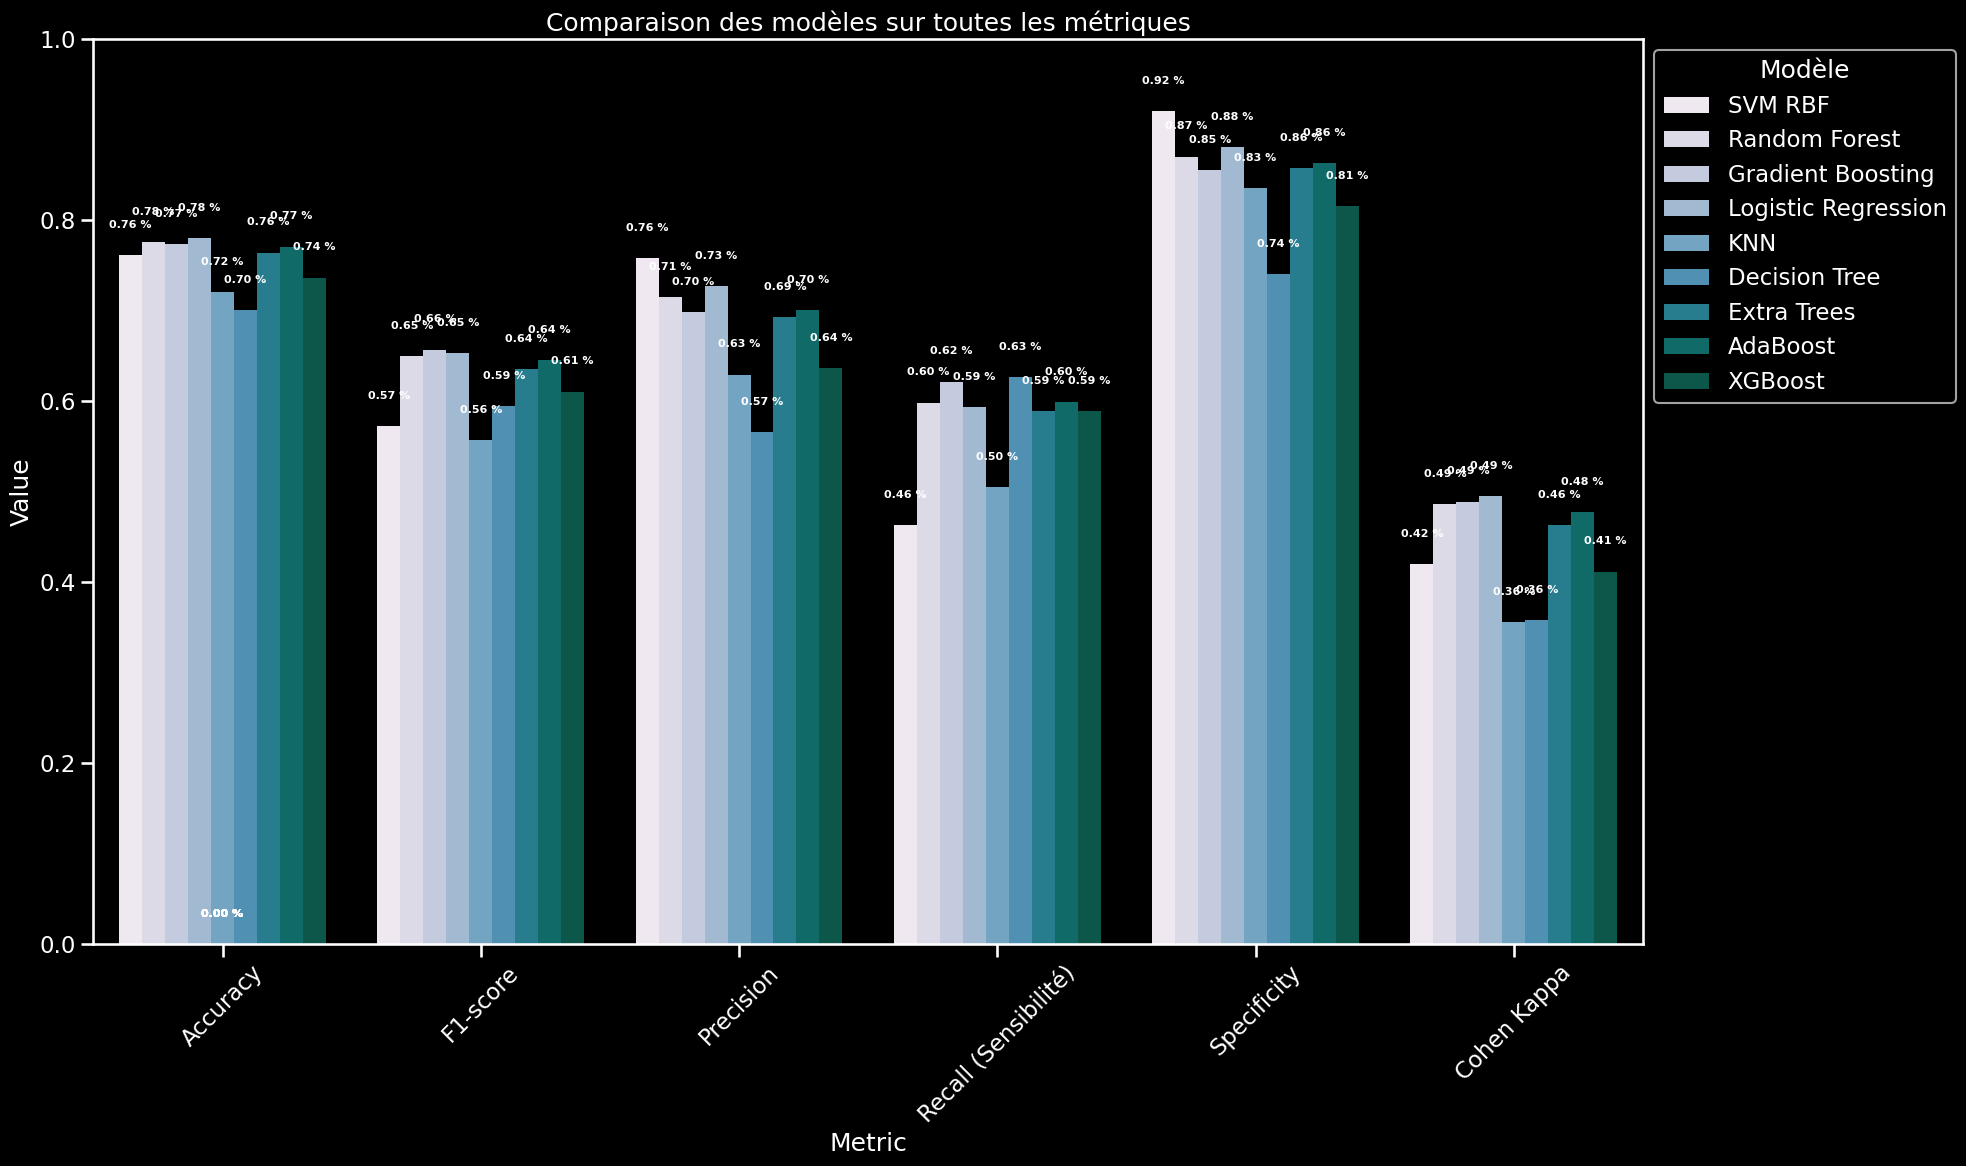

In [26]:
results_long = results_df.melt(id_vars="Model",
                               var_name="Metric",
                               value_name="Value")
plt.figure(figsize=(20,12))
bar = sns.barplot(data=results_long, x="Metric", y="Value", hue="Model", palette="PuBuGn")
plt.title("Comparaison des modèles sur toutes les métriques")
plt.legend(bbox_to_anchor=(1, 1), title="Modèle")
plt.xticks(rotation=45)

# Ajouter les valeurs au-dessus des barres
for patch in bar.patches:
    height = patch.get_height()
    bar.text(patch.get_x() + patch.get_width()/2., height + 0.03,  # léger offset
             f"{height:.2f} %", ha="center", fontsize=8,fontweight="bold")

plt.ylim(0,1)
plt.tight_layout()
plt.show()


## réglage du modéle de Régression logistique

#### Recherche par quadrillage

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = [
    {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100,1000],
     'classifier__penalty': ['l1','l2'],
     'classifier__solver':["liblinear"],
    'classifier__class_weight': [None, "balanced",{0:1, 1:3}, {0:1, 1:5},{0:1,1:10}]}
    ]


grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=3,
    scoring='f1',  # F1-score pour la classe 1
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best recall-score:", grid_search.best_score_)
print(classification_report(y_train, grid_search.predict(X_train)))
print("f1 score" , accuracy_score(y_train, grid_search.predict(X_train)))

Fitting 3 folds for each of 70 candidates, totalling 210 fits
Best parameters: {'classifier__C': 10, 'classifier__class_weight': {0: 1, 1: 3}, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best recall-score: 0.6966500085664332
              precision    recall  f1-score   support

           0       0.91      0.70      0.79       400
           1       0.61      0.87      0.72       214

    accuracy                           0.76       614
   macro avg       0.76      0.79      0.75       614
weighted avg       0.81      0.76      0.77       614

f1 score 0.760586319218241


In [28]:
print("Accuracy score" , accuracy_score(y_train, grid_search.predict(X_train)))


Accuracy score 0.760586319218241


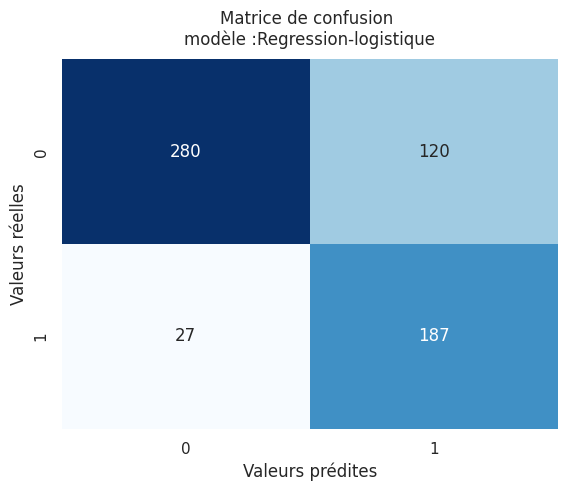

In [29]:
matrix = confusion_matrix(y_train, grid_search.predict(X_train))
sns.set_theme()
sns.heatmap(matrix,annot=True,fmt=".3g",cmap="Blues",cbar=False)
plt.title("Matrice de confusion \nmodèle :Regression-logistique",pad=10)
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

Le meilleur modèle de régression logistique atteint un F1-score de 0.72, soit +0.6 point par rapport au modèle initial.
La précision a fortement baissé (>10 %), mais le recall a augmenté de 3 %.
Cela signifie que le modèle génère plus de faux positifs, mais détecte mieux les diabétiques (moins de faux négatifs).
Étant donné l’importance de détecter la maladie, ce compromis est acceptable.
Nous allons maintenant pousser l’optimisation en utilisant Bayesian Optimization pour maximiser le recall et améliorer encore la détection

In [30]:
# pip install scikit-optimize


In [31]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical,Integer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
# Pipeline complet
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Définition de l'espace des hyperparamètres
param_space = {
    'classifier__C': Real(0.001, 100, prior='log-uniform'),
    'classifier__penalty': Categorical(['l1','l2']),
    'classifier__solver': Categorical(['liblinear']),  # adapté à l1/l2
    'classifier__class_weight': Categorical([None,'balanced'])
}

# BayesSearchCV
opt = BayesSearchCV(
    full_pipeline,
    search_spaces=param_space,
    n_iter=30,          # nombre d'itérations bayésiennes
    cv=3,
    scoring='recall',   # on maximise le recall pour la classe 1
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Entraînement
opt.fit(X_train, y_train)

# Résultats
print("Best parameters:", opt.best_params_)
print("Best recall-score:", opt.best_score_)
print(classification_report(y_train, opt.predict(X_train)))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

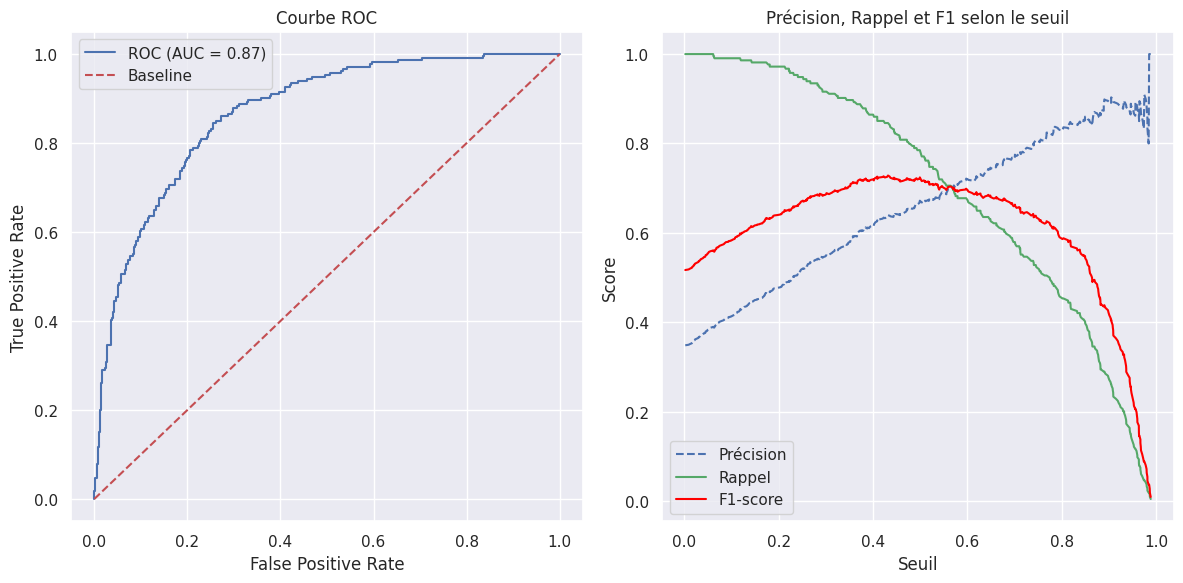

In [34]:
Seuils_log = draw_roc_pr_curves(opt,X_train,y_train)

In [263]:


# Seuils[Seuils["Rappel"] >=0.85].sort_values(by="Précision",ascending=False).head(2)
# #0.422465	0.850467	0.634146


In [35]:
seuils = 0.422465
y_pred = (opt.predict_proba(X_train)[:,1] >= seuils).astype(int)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81       400
           1       0.63      0.85      0.73       214

    accuracy                           0.78       614
   macro avg       0.77      0.79      0.77       614
weighted avg       0.81      0.78      0.78       614



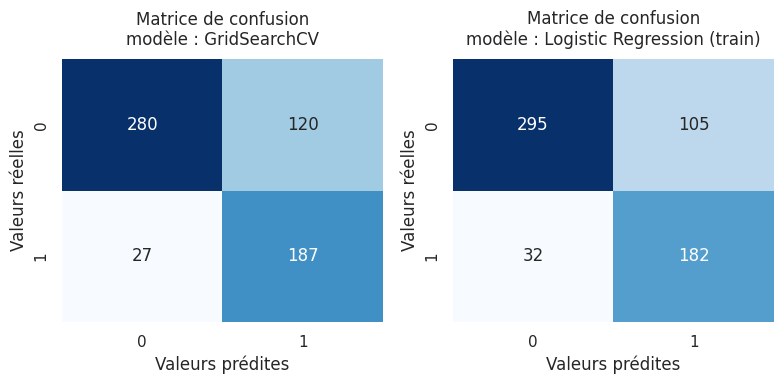

In [36]:

# Confusion matrices
Matrix_train = confusion_matrix(y_train, y_pred)
Matrix_grid = confusion_matrix(y_train, grid_search.predict(X_train))

sns.set_theme()

# Figure avec 2 sous-plots
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Heatmap pour y_pred
sns.heatmap(Matrix_train, annot=True, fmt=".3g", cmap="Blues", cbar=False, ax=ax[1])
ax[1].set_title("Matrice de confusion\nmodèle : Logistic Regression (train)", pad=10)
ax[1].set_xlabel("Valeurs prédites")
ax[1].set_ylabel("Valeurs réelles")

# Heatmap pour GridSearch
sns.heatmap(Matrix_grid, annot=True, fmt=".3g", cmap="Blues", cbar=False, ax=ax[0])
ax[0].set_title("Matrice de confusion\nmodèle : GridSearchCV", pad=10)
ax[0].set_xlabel("Valeurs prédites")
ax[0].set_ylabel("Valeurs réelles")

plt.tight_layout()
plt.show()


Après avoir ajusté manuellement le seuil, notre modèle détecte 85 % des diabétiques contre 80 % précédemment. Cette modification entraîne une légère baisse de précision de 2 %, qui reste à 63 % : dans 63 % des cas, les patients prédits comme diabétiques le sont réellement. Ce compromis privilégie la détection des cas positifs, essentielle dans un contexte médical pour réduire les faux négatifs.

Voyons voir maintenant es ce que le modéle généralise ou bien au contraire elle est en overfiting (sur-ajustement)

In [37]:
y_pred = opt.predict(X_test)
print("Évaluation sur le jeu de validation")
print()
print("----------------------------------------------------------------------------------")

print("Sans seuil défini")
print(classification_report(y_test, y_pred))
print("----------------------------------------------------------------------------------")
print()
y_pred_seuil = opt.predict_proba(X_test)[:,1] >= seuils
print("Avec le seuil défini sur le train_set")
print(classification_report(y_test, y_pred_seuil))

Évaluation sur le jeu de validation

----------------------------------------------------------------------------------
Sans seuil défini
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       100
           1       0.62      0.74      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.76      0.75      0.75       154

----------------------------------------------------------------------------------

Avec le seuil défini sur le train_set
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       100
           1       0.58      0.83      0.69        54

    accuracy                           0.73       154
   macro avg       0.73      0.76      0.73       154
weighted avg       0.78      0.73      0.74       154




---

### 1️ Sans ajustement du seuil

* Rappel 74 % pour la classe 1 (diabétiques) → 74 % des diabétiques sont détectés.
* Précision 62 % → parmi les prédictions positives, 62 % sont correctes.
* F1-score 0.67 → compromis modéré entre rappel et précision.

### 2️ Avec seuil ajusté

* Rappel 83 % pour les diabétiques → amélioration de la détection (+9 %).
* Précision 58 % → légère baisse (-4 %), plus de faux positifs.
* F1-score 0.69 → gain net grâce à l’augmentation du rappel.





Nous pourrions décider d’augmenter la précision afin de nous rapprocher de notre objectif en ajustant le seuil de décision.
Cependant, il ne s’agit pas de choisir un seuil au hasard.
Dans notre cas, nous avons décidé de fixer une contrainte : le seuil doit garantir une précision minimale de 65%.
Parmi les seuils respectant cette contrainte (dans l’intervalle [0.65, 1]), nous retenons celui qui maximise le score F1.

----------------------------------------------------------------------------------------------------
Seuil choisi : 0.471 (maximisation du rappel avec précision ≥ 0.65)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       400
           1       0.65      0.81      0.72       214

    accuracy                           0.78       614
   macro avg       0.77      0.79      0.77       614
weighted avg       0.80      0.78      0.79       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       100
           1       0.62      0.81      0.70        54

    accuracy                           0.76       154
   macro avg       0.75      0.77      0.75       154
weighted avg       0.79      0.76      0.76       154

----------------------------------

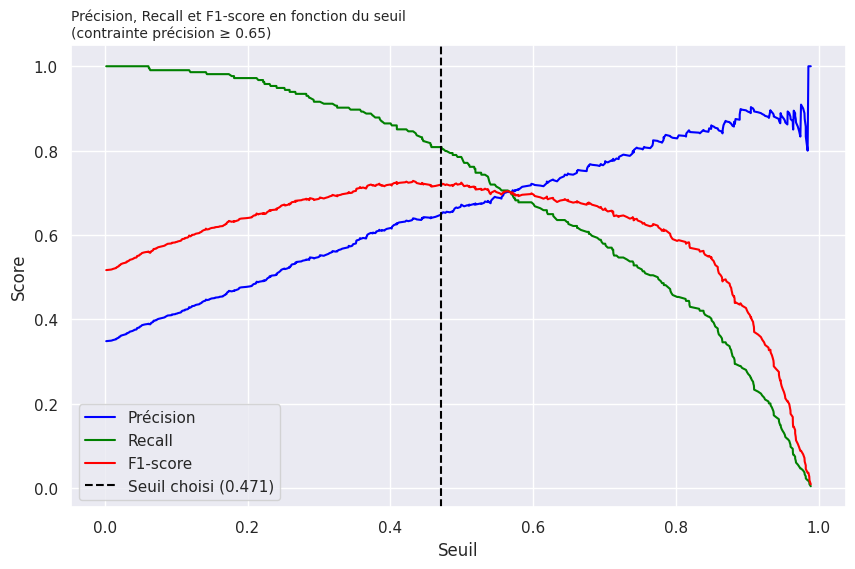

In [262]:
seuil =  evaluate_with_threshold(opt,X_train,y_train,X_test,y_test,min_precision=0.65)
# Summary = pd.concat([
#     Summary ,
#     compute_resume_scoring(opt,"Regression_logistique",X_test,y_test,seuil)
# ])

###  Conclusion

* Le **réglage du seuil** améliore la détection des diabétiques, ce qui est crucial dans un contexte médical, même au prix d’une légère baisse de précision.
* Le modèle **généralise correctement** sur le jeu de validation : rappel et précision restent cohérents avec les performances sur le train.

---

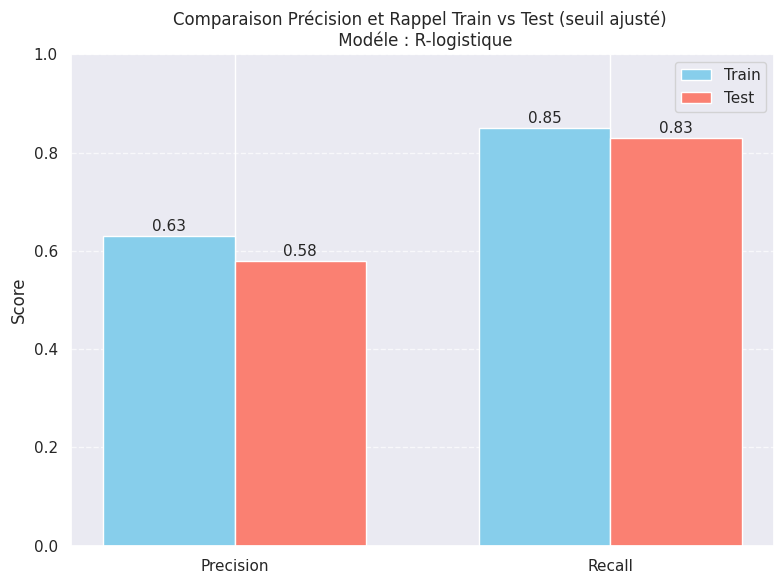

In [38]:


# Scores pour train et test
metrics = ['Precision', 'Recall']
train_scores = [0.63, 0.85]  # train, seuil ajusté
test_scores  = [0.58, 0.83]  # test, seuil ajusté

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, train_scores, width, label='Train', color='skyblue')
plt.bar(x + width/2, test_scores, width, label='Test', color='salmon')

# Annoter les valeurs
for i, val in enumerate(train_scores):
    plt.text(i - width/2, val + 0.01, f"{val:.2f}", ha='center', fontsize=11)
for i, val in enumerate(test_scores):
    plt.text(i + width/2, val + 0.01, f"{val:.2f}", ha='center', fontsize=11)

plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Comparaison Précision et Rappel Train vs Test (seuil ajusté) \n Modéle : R-logistique")
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [39]:
# ## sauvegarde du modele de regression_logistiQue
# import joblib
# joblib.dump(opt, 'Regression_logistique.pkl')

## Xgbboost

#### Réglage du modéle

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from skopt.space import Real, Integer

full_pipeline_xgb = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', XGBClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],            # Nombre d'arbres
    'classifier__learning_rate': [0.01, 0.05, 0.1],         # Learning rate (vitesse de cvg DG)
    'classifier__max_depth': [3, 4, 5,10],                     # Profondeur des arbres
    'classifier__subsample': [0.7, 0.8, 1.0],               # Fraction d’échantillons par arbre
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],        # Fraction de features par arbre
    'classifier__gamma': [0, 0.1, 0.2,0.5,1],                     # Regularisation sur les splits
    'classifier__reg_alpha': [0, 0.01, 0.1,0.5,1],                # L1 regularization
    'classifier__reg_lambda': [1, 1.5, 2]                   # L2 regularization
}

random_grid_xgb_search = RandomizedSearchCV(
    full_pipeline_xgb,
    param_grid,
    n_iter=50,
    cv=3,
    scoring="recall",   # On maximise le rappel pour détecter le diabète
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Entraînement
random_grid_xgb_search.fit(X_train, y_train)

# Résultats
print("Best parameters:", random_grid_xgb_search.best_params_)
print("Best recall-score:", random_grid_xgb_search.best_score_)



# Espace des hyperparamètres valides pour XGBClassifier
param_space = {
    'classifier__n_estimators': Integer(50, 300),
    'classifier__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'classifier__max_depth': Integer(2, 15),
    'classifier__subsample': Real(0.6, 1.0),
    'classifier__colsample_bytree': Real(0.6, 1.0),
    'classifier__gamma': Real(0, 0.5),
    'classifier__reg_alpha': Real(0, 0.1),
    'classifier__reg_lambda': Real(1, 2)
}

# BayesSearchCV
opt_xgb = BayesSearchCV(
    full_pipeline_xgb,
    search_spaces=param_space,
    n_iter=30,
    cv=3,
    scoring='recall',   # on maximise le rappel pour détecter le diabète
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Entraînement
opt_xgb.fit(X_train, y_train)

# Résultats
print("Best parameters:", opt_xgb.best_params_)
print("Best recall-score:", opt_xgb.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'classifier__subsample': 0.8, 'classifier__reg_lambda': 2, 'classifier__reg_alpha': 0.5, 'classifier__n_estimators': 200, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.8}
Best recall-score: 0.602960354720918
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, tot

La recherche des meilleurs hyperparamètres via Bayesienne et RandomizedSearchCV a donné des résultats très proches.
Nous choisissons finalement les paramètres issus de la recherche aléatoire car ils offrent des performances légèrement supérieures en rappel sur la classe 1 (diabète), ce qui est notre objectif principal.
Cette approche nous permet de maximiser la détection des patients diabétiques tout en conservant une précision acceptable pour limiter les faux positifs.
Ainsi, le modèle final sera celui entraîné avec ces paramètres issus de la recherche aléatoire.

In [41]:
best_xgb = random_grid_xgb_search.best_estimator_
print("Best parameters:", random_grid_xgb_search.best_params_)
print("Best recall-score:", random_grid_xgb_search.best_score_)
print(classification_report(y_train, best_xgb.predict(X_train)))

Best parameters: {'classifier__subsample': 0.8, 'classifier__reg_lambda': 2, 'classifier__reg_alpha': 0.5, 'classifier__n_estimators': 200, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.8}
Best recall-score: 0.602960354720918
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       214

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



Même si le modèle affiche des performances spectaculaires sur le jeu d’entraînement, cela confirme en réalité un sur-ajustement. Il a mémorisé ses données d’entraînement plutôt que d’apprendre des règles généralisables, ce qui se traduit par une précision et un rappel artificiellement élevés. L’évaluation sur un jeu de validation reste indispensable pour mesurer sa vraie capacité à détecter le diabète sur des patients jamais vus.

Mais avant cela essayons de réduire le sur-ajustement en régularisant le modèle

*

In [42]:


param_space = {
    'classifier__n_estimators': Integer(50, 300),
    'classifier__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'classifier__max_depth': Integer(2, 20),
    'classifier__subsample': Real(0.6, 1.0),
    'classifier__colsample_bytree': Real(0.6, 1.0),
    'classifier__gamma': Real(0, 0.5),
    'classifier__reg_alpha': Real(0, 5.0),   # Augmenté pour plus de L1
    'classifier__reg_lambda': Real(1, 5),    # Augmenté pour plus de L2
    'classifier__min_child_weight': Integer(1, 10)  # Nouveau paramètre pour régularisation
}

opt_xgb = BayesSearchCV(
    full_pipeline_xgb,
    search_spaces=param_space,
    n_iter=50,
    n_points=10,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

opt_xgb.fit(X_train, y_train)

print("Best parameters:", opt_xgb.best_params_)
print("Best recall-score:", opt_xgb.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: OrderedDict({'classifier__colsample_bytree': 0.8316255000573943, 'classifier__gamma': 0.3534258226170032, 'classifier__learning_rate': 0.016365378442553216, 'classifier__max_depth': 17, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 300, 'classifier__reg_alpha': 1.502716641740451, 'classifier__reg_lambda': 4.189021131313752, 'classifier__subsample': 0.6})
Best recall-score: 0.6586570300963037


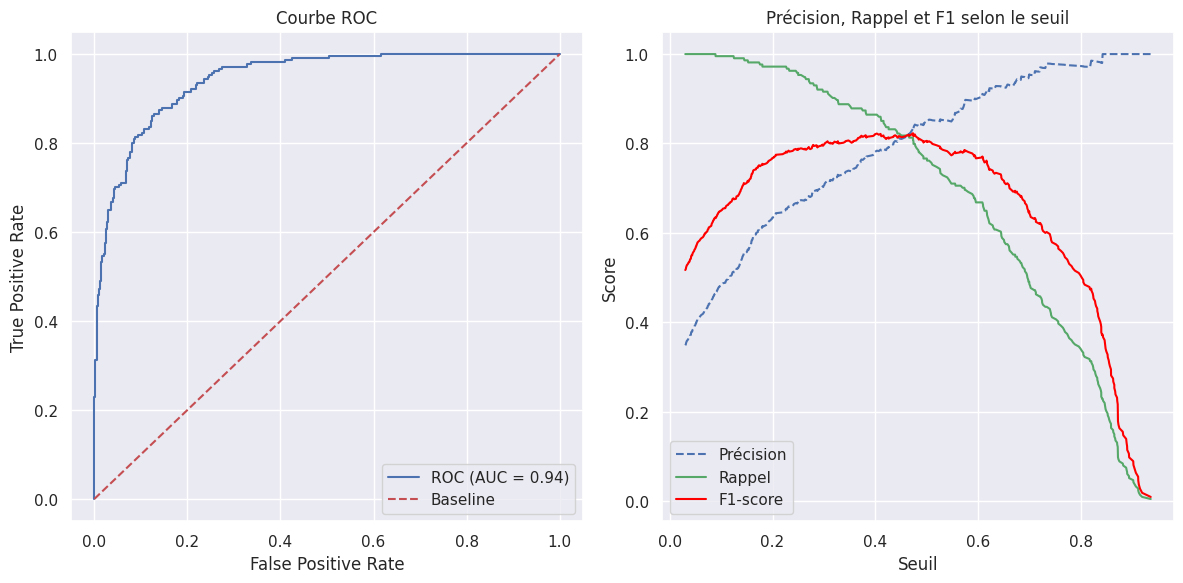

In [43]:
Seuils_xgb = draw_roc_pr_curves(opt_xgb,X_train,y_train)

----------------------------------------------------------------------------------------------------
Seuil choisi : 0.297 (maximisation du rappel avec précision ≥ 0.7)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       400
           1       0.70      0.92      0.80       214

    accuracy                           0.84       614
   macro avg       0.83      0.86      0.83       614
weighted avg       0.86      0.84      0.84       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       100
           1       0.61      0.83      0.70        54

    accuracy                           0.75       154
   macro avg       0.75      0.77      0.75       154
weighted avg       0.79      0.75      0.76       154

-----------------------------------

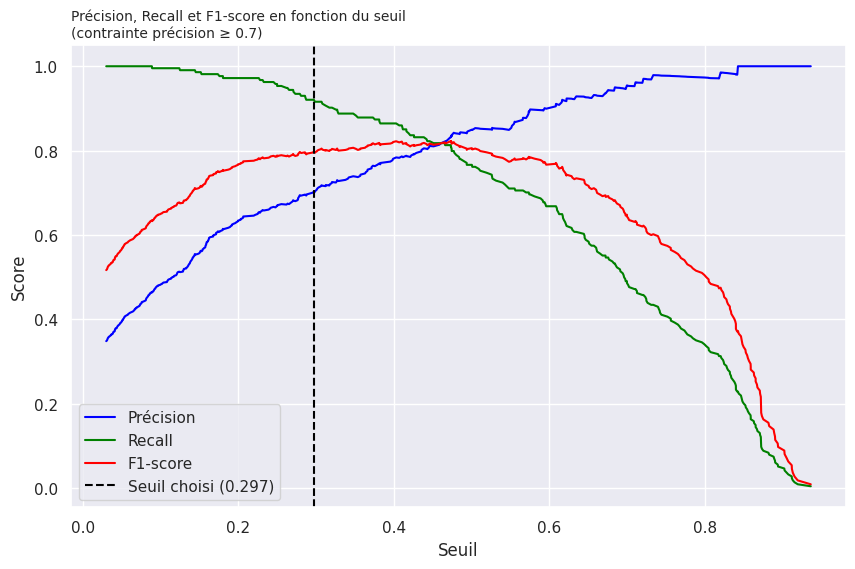

In [247]:
best_threshold_xgb=evaluate_with_threshold(opt_xgb )

# Summary = pd.concat(
#     [
#         Summary,
#         compute_resume_scoring(opt_xgb,"XGBoost",X_test,y_test,best_threshold_xgb)
#     ]
# )

Le modèle XGBoost avec le seuil ajusté parvient à atteindre un bon rappel (83%) sur le jeu de test pour la détection des diabétiques, ce qui est un objectif clinique important. Cependant, le sur-ajustement observé indique qu'il pourrait être amélioré pour mieux généraliser. La précision sur la classe 1 est modérée (61%), ce qui implique qu'il y aura un nombre significatif de faux positifs. Le compromis entre rappel élevé et précision modérée est ici privilégié pour minimiser les faux négatifs, mais il est important d'être conscient de ce compromis.

Des efforts supplémentaires pourraient être faits pour réduire le sur-ajustement.

## GBoosting Classifier

### Tunning

In [45]:

# # Calcul automatique du poids (inverse de la fréquence des classes)
# from collections import Counter
# class_counts = Counter(y_train)
# scale_pos_weight = class_counts[0] / class_counts[1]  # poids ~ n_negatifs / n_positifs

# print(f"Poids appliqué aux classes : {scale_pos_weight:.2f}")

# # Fonction objectif Optuna
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 2, 10),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
#         "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
#         "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
#         "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
#     }

#     model = GradientBoostingClassifier(**params, random_state=42)

#     pipe = Pipeline([
#         ('preprocessing', preprocessing),
#         ('classifier', model)
#     ])

#     # Ici on ajoute des poids de classes dans le scoring
#     sample_weights = np.where(y_train == 1, scale_pos_weight, 1)

#     score = cross_val_score(
#         pipe, X_train, y_train,
#         cv=3,
#         scoring="f1",
#         # fit_params={"classifier__sample_weight": sample_weights},
#         n_jobs=-1
#     ).mean()

#     return score

# # Lancer l’étude
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True)

# #  Résultats
# print("Best parameters:", study.best_params)
# print("Best F1-score:", study.best_value)

# # Réentraîner le pipeline final avec pondération
# best_pipeline_gb = Pipeline([
#     ('preprocessing', preprocessing),
#     ('classifier', GradientBoostingClassifier(**study.best_params, random_state=42))
# ])

# sample_weights = np.where(y_train == 1, scale_pos_weight, 1)
# best_pipeline_gb.fit(X_train, y_train, classifier__sample_weight=sample_weights)




[I 2025-09-11 18:46:07,314] A new study created in memory with name: no-name-043ef863-db60-42f0-8fa9-a2fed0bc1e7f


Poids appliqué aux classes : 1.87


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-11 18:46:11,318] Trial 0 finished with value: 0.40230291447682753 and parameters: {'n_estimators': 145, 'learning_rate': 0.003063015534082742, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 2, 'subsample': 0.7555330749817124, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.40230291447682753.
[I 2025-09-11 18:46:12,415] Trial 1 finished with value: 0.6249920682991549 and parameters: {'n_estimators': 261, 'learning_rate': 0.01958190337440324, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 5, 'subsample': 0.8284222207742575, 'max_features': None}. Best is trial 1 with value: 0.6249920682991549.
[I 2025-09-11 18:46:14,832] Trial 2 finished with value: 0.6079926823808317 and parameters: {'n_estimators': 250, 'learning_rate': 0.010291389176158041, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 17, 'subsample': 0.8923791416604034, 'max_features': None}. Best is trial 1 with value: 0.6249920682991549.
[I 2025-09-11 18:46:21,741] Trial

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('outlier',
                                                  Pipeline(steps=[('capper',
                                                                   OutlierCapper(columns=['Glucose',
                                                                                          'BloodPressure',
                                                                                          'SkinThickness',
                                                                                          'Insulin',
                                                                                          'BMI']))]),
                                                  ['Glucose', 'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI']),
                                                 ('num',
                                                  Pipeline(steps=[('zero_to_nan',
                                                                   ZeroToNan(columns=['Glucose',
                                                                                      'BloodPressure',
                                                                                      'SkinThickness',
                                                                                      'I...
                                                                  ('functiontransformer-2',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Glucose', 'BMI'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.008404879938756184,
                                            max_depth=6, max_features='sqrt',
                                            min_samples_leaf=7,
                                            min_samples_split=9,
                                            n_estimators=555, random_state=42,
                                            subsample=0.6269150913953996))])

In [46]:


# Poids automatiques basés sur le déséquilibre
class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"Poids appliqué aux classes positives : {scale_pos_weight:.2f}")

def objective(trial):
    params = {
        # Nombre d’arbres : plus d’arbres = meilleure stabilité mais risque overfit
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),

        # Taux d’apprentissage : plus petit = plus stable mais + d’arbres nécessaires
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),

        # Profondeur : contrôle la complexité de chaque arbre
        "max_depth": trial.suggest_int("max_depth", 2, 6),

        # Nombre min d’échantillons pour split → évite les arbres trop spécifiques
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),

        # Nombre min de feuilles → réduit le sur-apprentissage
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 15),

        # Proportion d’échantillons utilisés → améliore la robustesse (bagging)
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),

        # Features utilisées → évite corrélation excessive
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),

        # Régularisation L2 des feuilles (empêche gros poids sur un split)
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0.0, 0.2)
    }

    model = GradientBoostingClassifier(**params, random_state=42)

    pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('classifier', model)
    ])

    # Poids par classe
    sample_weights = np.where(y_train == 1, scale_pos_weight, 1)

    score = cross_val_score(
        pipe, X_train, y_train,
        cv=3,
        scoring="f1",
        n_jobs=-1
    ).mean()

    return score

# Étude Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

print("Best parameters:", study.best_params)
print("Best F1-score:", study.best_value)

# Réentraîner modèle final
best_pipeline_gb = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', GradientBoostingClassifier(**study.best_params, random_state=42))
])

sample_weights = np.where(y_train == 1, scale_pos_weight, 1)
best_pipeline_gb.fit(X_train, y_train, classifier__sample_weight=sample_weights)


[I 2025-09-11 18:49:51,617] A new study created in memory with name: no-name-a15f3238-1c40-4fc7-b178-962264024bd5


Poids appliqué aux classes positives : 1.87


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-11 18:49:54,888] Trial 0 finished with value: 0.6295886859215553 and parameters: {'n_estimators': 348, 'learning_rate': 0.029745456545254043, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 6, 'subsample': 0.7566923919215838, 'max_features': None, 'min_impurity_decrease': 0.1245681803227327}. Best is trial 0 with value: 0.6295886859215553.
[I 2025-09-11 18:49:56,166] Trial 1 finished with value: 0.6285383479059368 and parameters: {'n_estimators': 301, 'learning_rate': 0.01286041830100645, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 3, 'subsample': 0.9753162038349791, 'max_features': 'log2', 'min_impurity_decrease': 0.10772251692003423}. Best is trial 0 with value: 0.6295886859215553.
[I 2025-09-11 18:49:59,514] Trial 2 finished with value: 0.587153676034939 and parameters: {'n_estimators': 587, 'learning_rate': 0.1064047088917394, 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 10, 'subsample': 0.6853015005061958, 'max_features': 'l

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('outlier',
                                                  Pipeline(steps=[('capper',
                                                                   OutlierCapper(columns=['Glucose',
                                                                                          'BloodPressure',
                                                                                          'SkinThickness',
                                                                                          'Insulin',
                                                                                          'BMI']))]),
                                                  ['Glucose', 'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI']),
                                                 ('num',
                                                  Pipeline(steps=[('zero_to_nan',
                                                                   ZeroToNan(columns=['Glucose',
                                                                                      'BloodPressure',
                                                                                      'SkinThickness',
                                                                                      'I...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Glucose', 'BMI'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.02890725102928783,
                                            max_depth=6, max_features='sqrt',
                                            min_impurity_decrease=0.13633740408674225,
                                            min_samples_leaf=6,
                                            min_samples_split=15,
                                            n_estimators=243, random_state=42,
                                            subsample=0.6488150690359634))])

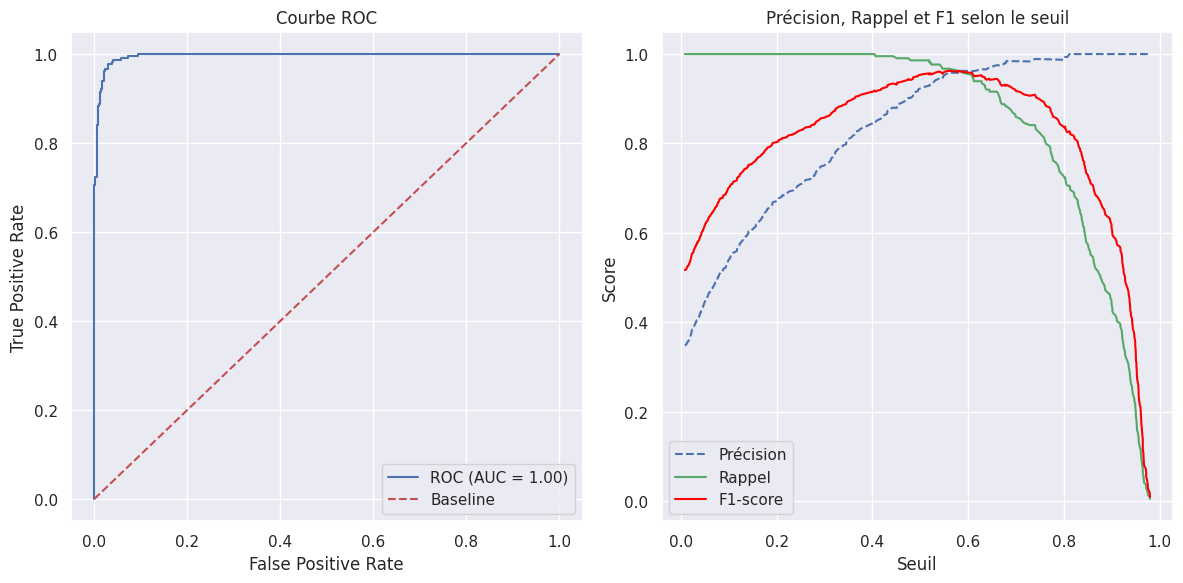

In [47]:
Seuils_gb =draw_roc_pr_curves(best_pipeline_gb,X_train,y_train)

In [ ]:
# Seuils_gb[(Seuils_gb['Rappel'] >= 0.9) & (Seuils_gb['Précision'] >= 0.6)].sort_values(by="Rappel",ascending=False).head(20)

----------------------------------------------------------------------------------------------------
Seuil choisi : 0.345 (maximisation du rappel avec précision ≥ 0.8)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       400
           1       0.80      1.00      0.89       214

    accuracy                           0.91       614
   macro avg       0.90      0.93      0.91       614
weighted avg       0.93      0.91      0.92       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       100
           1       0.60      0.80      0.68        54

    accuracy                           0.74       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.77      0.74      0.75       154

-----------------------------------

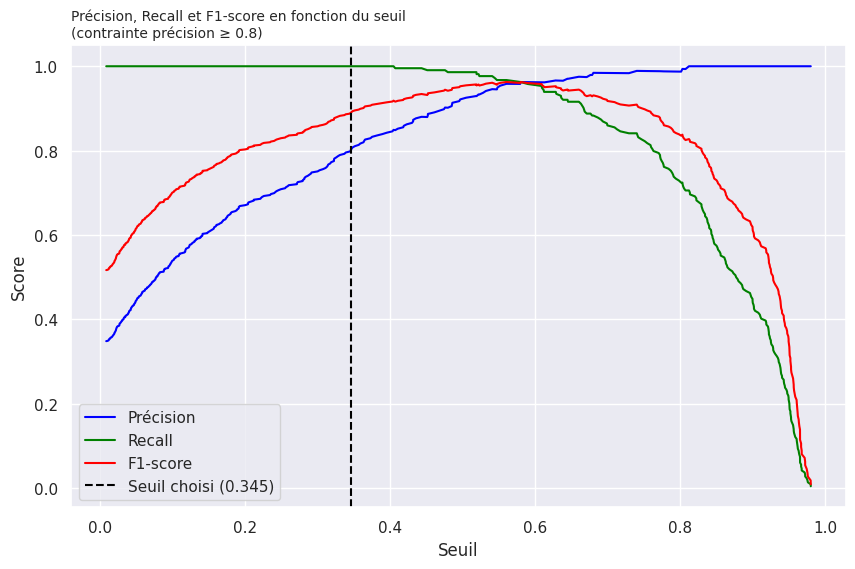

In [245]:
best_threshold = evaluate_with_threshold(best_pipeline_gb, X_train, y_train, X_test, y_test, min_precision=0.8)
# Summary = pd.concat(
#     [
#         Summary,
#         compute_resume_scoring(best_pipeline_gb,"Gradient Boosting",X_test,y_test,best_threshold)
#     ]
# )

## Random Forest

In [239]:


# # Pipeline avec preprocessing
# rf_pipeline = Pipeline([
#     ('preprocessing', preprocessing),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# # Espace des hyperparamètres
# param_space = {
#     'classifier__n_estimators': Integer(50, 500),
#     'classifier__max_depth': Integer(3, 9),
#     'classifier__min_samples_split': Integer(5, 10),
#     'classifier__min_samples_leaf': Integer(5, 12),
#     'classifier__max_features': Categorical(['sqrt', 'log2']),
#     'classifier__criterion': Categorical(['gini', 'entropy']),
#     'classifier__bootstrap': Categorical([True, False]),
#     'classifier__class_weight': Categorical(['balanced'])
# }

# # BayesSearchCV
# bayes_search = BayesSearchCV(
#     rf_pipeline,
#     search_spaces=param_space,
#     n_iter=30,  # nombre d'itérations
#     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     scoring='f1',  # ou 'roc_auc', 'recall'
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
# )

# # Lancer l’optimisation
# bayes_search.fit(X_train, y_train)

# # Meilleurs paramètres et score
# print("Best params:", bayes_search.best_params_)
# print("Best F1-score:", bayes_search.best_score_)



In [50]:


# Pipeline avec preprocessing
rf_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Espace des hyperparamètres
param_space = {
    # Nombre d’arbres – plus d’arbres = variance plus faible mais temps plus long
    'classifier__n_estimators': Integer(50, 800),

    # Profondeur max – 3 à 12 était bien, mais ajouter jusqu’à 20 permet de tester si un RF plus profond
    # peut mieux capturer les interactions. Sur un petit dataset, >15 peut surapprendre, mais BayesSearch gérera ça.
    'classifier__max_depth': Integer(3, 20),

    # Nombre minimal d’échantillons pour un split
    # Mettre une fourchette plus large (2–20) → équilibre entre underfitting (trop haut) et overfitting (trop bas).
    'classifier__min_samples_split': Integer(2, 20),

    # Nombre minimal d’échantillons par feuille
    # Passer de 1 à 20 → plus haut réduit variance, utile pour dataset petit et déséquilibré comme diabète.
    'classifier__min_samples_leaf': Integer(1, 20),

    # Fraction de features à tester à chaque split
    'classifier__max_features': Categorical(['sqrt', 'log2', None, 0.5]),
    # J’ajoute 0.5 (50% des features) → utile quand peu de variables (~8 dans diabète), ça peut stabiliser les splits.

    # Fonction de mesure d’impureté
    'classifier__criterion': Categorical(['gini', 'entropy', 'log_loss']),
    # j’ajoute 'log_loss' → dispo depuis sklearn 1.1, utile quand on veut calibrer les probabilités.

    # Bootstrap – classique True, mais parfois False = proche ExtraTrees, intéressant à tester
    'classifier__bootstrap': Categorical([True, False]),

    # Pondération des classes
    'classifier__class_weight': Categorical([None, 'balanced', 'balanced_subsample']),
    # j’ajoute 'balanced_subsample' → ajuste automatiquement les poids à chaque bootstrap, pratique pour déséquilibre.

    # Min impurity decrease – évite des splits inutiles s’ils n’améliorent pas assez
    'classifier__min_impurity_decrease': Real(0.001, 0.01, prior='log-uniform'),

    # Ccp alpha (post-pruning) – utile pour contrôler la complexité finale
    'classifier__ccp_alpha': Real(0.001, 0.05, prior='log-uniform')
}

# Pipeline avec preprocessing
rf_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])

# BayesSearchCV avec multi-métriques
bayes_search = BayesSearchCV(
    estimator=rf_pipeline,
    search_spaces=param_space,   # ton espace enrichi
    n_iter=60,                   # assez d’itérations pour explorer
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring={
        'f1': 'f1',
        'roc_auc': 'roc_auc',
        'recall': 'recall'
    },
    refit='f1',   # critère principale
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Entraînement
bayes_search.fit(X_train, y_train)

# Résultats
print("Best params:", bayes_search.best_params_)
print("Best score (F1 refit):", bayes_search.best_score_)

# Accès aux scores pour toutes les métriques
cv_results = bayes_search.cv_results_
for metric in ['f1', 'roc_auc', 'recall']:
    mean_score = cv_results[f'mean_test_{metric}'][bayes_search.best_index_]
    print(f"Best {metric}: {mean_score:.4f}")





Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

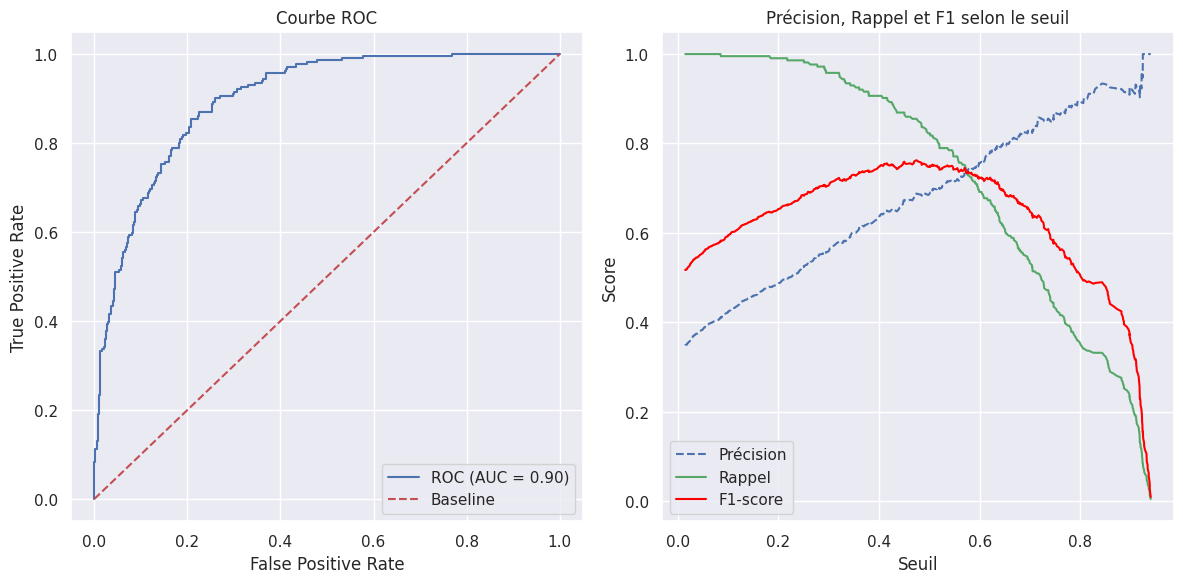

In [51]:
rf_clf = bayes_search.best_estimator_
Seuils_rf = draw_roc_pr_curves(rf_clf,X_train,y_train)


----------------------------------------------------------------------------------------------------
Seuil choisi : 0.469 (maximisation du rappel avec précision ≥ 0.68)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.91      0.79      0.84       400
           1       0.68      0.86      0.76       214

    accuracy                           0.81       614
   macro avg       0.80      0.82      0.80       614
weighted avg       0.83      0.81      0.81       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       100
           1       0.63      0.83      0.72        54

    accuracy                           0.77       154
   macro avg       0.76      0.79      0.76       154
weighted avg       0.80      0.77      0.78       154

----------------------------------

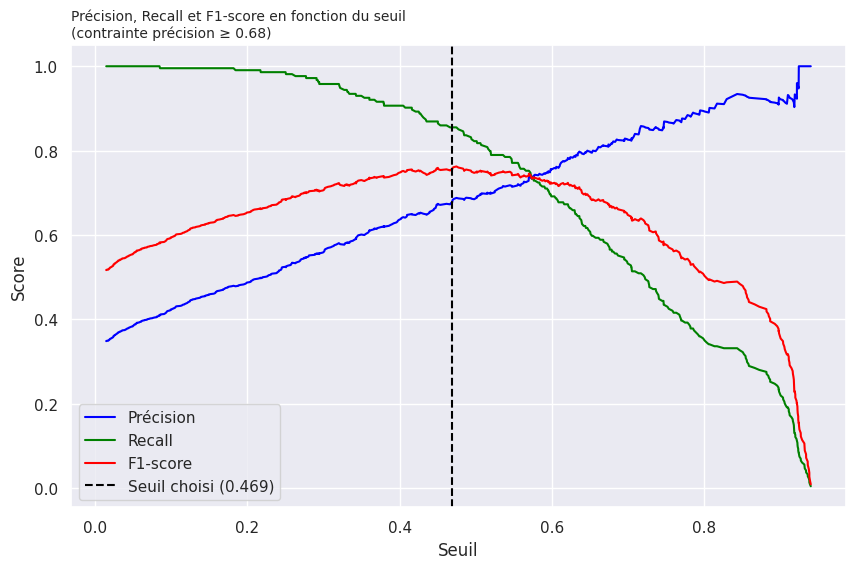

In [244]:
best_threshold = evaluate_with_threshold(bayes_search, X_train, y_train, X_test, y_test, min_precision=0.68)

# Summary = pd.concat(
#     [
#         Summary,
#         compute_resume_scoring(bayes_search,"Random Forest",X_test,y_test,best_threshold)
#     ]
# )

Le modèle Random Forest optimisé est capable de détecter correctement les patients diabétiques tout en gardant une précision acceptable (>60%). Le rappel priorisé permet de réduire les faux négatifs (patients mal détectés), au prix d’un peu plus de faux positifs.

## Stacking

In [226]:


# Définir SMOTE
smote = SMOTE(random_state=42)

# Fonction objectif pour Optuna
def objective(trial, model_type="lr"):

    if model_type == "lr":
        # Hyperparamètres LR
        params = {
            "C": trial.suggest_loguniform("C", 1e-3, 1e3),
            "penalty": trial.suggest_categorical("penalty", ["l2", None]),
            "solver": "lbfgs",
            "max_iter": 1000
        }
        model = LogisticRegression(**params, random_state=42)

    else:
        # Hyperparamètres Gradient Boosting
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
            "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        }
        model = GradientBoostingClassifier(**params, random_state=42)

    # Pipeline avec SMOTE
    pipe = ImbPipeline([
        ("smote", smote),
        ("classifier", model)
    ])

    # Cross-validation
    score = cross_val_score(
        pipe, X_train, y_train,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score),
        n_jobs=-1
    ).mean()

    return score

# Étude Optuna pour LogisticRegression
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(lambda trial: objective(trial, model_type="lr"), n_trials=50, n_jobs=1, show_progress_bar=True)

print("=== Logistic Regression ===")
print("Best params:", study_lr.best_params)
print("Best F1-score:", study_lr.best_value)

# Étude Optuna pour Gradient Boosting
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(lambda trial: objective(trial, model_type="gb"), n_trials=50, n_jobs=1, show_progress_bar=True)

print("=== Gradient Boosting ===")
print("Best params:", study_gb.best_params)
print("Best F1-score:", study_gb.best_value)


# --------------------------
# Réentraîner les pipelines finaux
# --------------------------
opt_gbm_smote = ImbPipeline([
    ("smote", smote),
    ("classifier", GradientBoostingClassifier(**study_gb.best_params, random_state=42))
])
opt_gbm_smote.fit(X_train, y_train)

opt_lr_smote = ImbPipeline([
    ("smote", smote),
    ("classifier", LogisticRegression(**study_lr.best_params, random_state=42))
])
opt_lr_smote.fit(X_train, y_train)

# --------------------------
# Évaluation
# --------------------------
print("------ GradientBoosting Train ------")
print(classification_report(y_train, opt_gbm_smote.predict(X_train)))
print("------ GradientBoosting Test ------")
print(classification_report(y_test, opt_gbm_smote.predict(X_test)))

print("------ LogisticRegression Train ------")
print(classification_report(y_train, opt_lr_smote.predict(X_train)))
print("------ LogisticRegression Test ------")
print(classification_report(y_test, opt_lr_smote.predict(X_test)))

------ GradientBoosting Train ------
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       400
           1       0.69      0.82      0.75       214

    accuracy                           0.81       614
   macro avg       0.79      0.81      0.79       614
weighted avg       0.82      0.81      0.81       614

------ GradientBoosting Test ------
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       100
           1       0.63      0.80      0.70        54

    accuracy                           0.77       154
   macro avg       0.75      0.77      0.76       154
weighted avg       0.79      0.77      0.77       154

------ LogisticRegression Train ------
              precision    recall  f1-score   support

           0       0.85      0.78      0.82       400
           1       0.65      0.75      0.69       214

    accuracy                           0.77       614
   macro avg    

----------------------------------------------------------------------------------------------------
Seuil choisi : 0.513 (maximisation du rappel avec précision ≥ 0.7)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       400
           1       0.70      0.81      0.75       214

    accuracy                           0.81       614
   macro avg       0.79      0.81      0.80       614
weighted avg       0.82      0.81      0.82       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       100
           1       0.65      0.80      0.72        54

    accuracy                           0.78       154
   macro avg       0.76      0.78      0.77       154
weighted avg       0.80      0.78      0.78       154

-----------------------------------

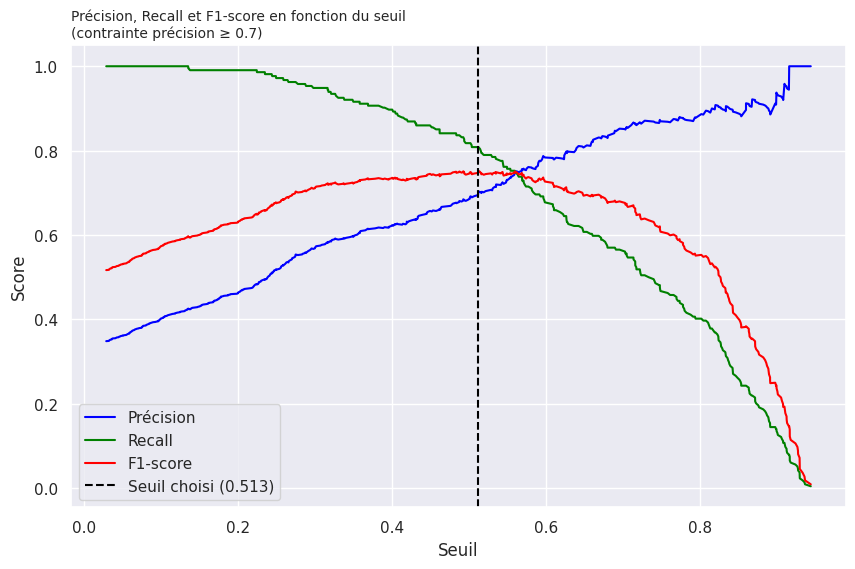

----------------------------------------------------------------------------------------------------
Seuil choisi : 0.460 (maximisation du rappel avec précision ≥ 0.6)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       400
           1       0.60      0.77      0.67       214

    accuracy                           0.74       614
   macro avg       0.73      0.75      0.73       614
weighted avg       0.77      0.74      0.75       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       100
           1       0.62      0.80      0.70        54

    accuracy                           0.76       154
   macro avg       0.75      0.77      0.75       154
weighted avg       0.78      0.76      0.76       154

-----------------------------------

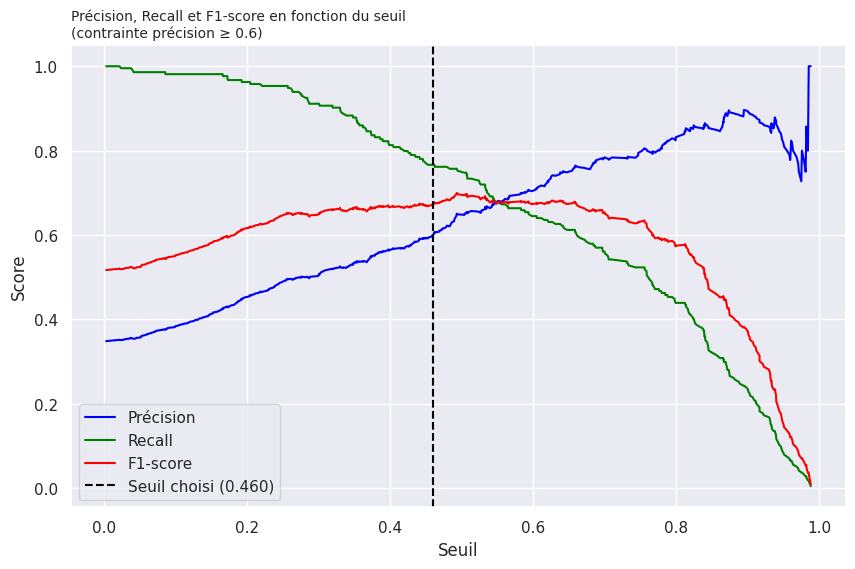

In [243]:
th_gbm_smote =evaluate_with_threshold(opt_gbm_smote, X_train, y_train, X_test, y_test, min_precision=0.7)
th_lr_smote =evaluate_with_threshold(opt_lr_smote, X_train, y_train, X_test, y_test, min_precision=0.6)

# Summary =pd.concat([
#     Summary,
#     compute_resume_scoring(opt_gbm_smote,"GradientBoosting_stack_0 Smote",X_test,y_test,th_gbm_smote)
#     ,compute_resume_scoring(opt_lr_smote,"Regression Logistique_stack_0 Smote ",X_test,y_test,th_lr_smote)
#     ])

In [55]:


# SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)

# Estimators déjà optimisés (GradientBoosting et LogisticRegression)
estimators = [
    ('gb', best_gb.named_steps['classifier']),
    ('lr', best_lr.named_steps['classifier'])
]

# Fonction objectif pour Optuna
def objective(trial):
    # Hyperparamètres du méta-estimateur (final_estimator)
    final_model = GradientBoostingClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        max_depth=trial.suggest_int("max_depth", 2, 10),
        random_state=42
    )

    stack = ImbPipeline([
        ("smote", smote),
        ("stacking", StackingClassifier(
            estimators=estimators,
            final_estimator=final_model,
            cv=3,
            n_jobs=-1
        ))
    ])

    score = cross_val_score(
        stack, X_train, y_train,
        cv=3,
        scoring=make_scorer(f1_score),
        n_jobs=-1
    ).mean()

    return score

# Étude Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

print("Best hyperparams for meta-estimator:", study.best_params)
print("Best F1-score CV:", study.best_value)

# Réentraînement du modèle final
final_model = GradientBoostingClassifier(**study.best_params, random_state=42)
stack_final = StackingClassifier(
    estimators=estimators,
    final_estimator=final_model,
    cv=3,
    n_jobs=-1
)
stack_pipeline = ImbPipeline([
    ("smote", smote),
    ("stacking", stack_final)
])

stack_pipeline.fit(X_train, y_train)

# Évaluation
from sklearn.metrics import classification_report
print("------ Train ------")
print(classification_report(y_train, stack_pipeline.predict(X_train)))
print("------ Test ------")
print(classification_report(y_test, stack_pipeline.predict(X_test)))


[I 2025-09-11 19:08:38,632] A new study created in memory with name: no-name-c068d7e1-abba-4f7d-8736-1facedd881c3


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-11 19:08:51,698] Trial 0 finished with value: 0.639521903672847 and parameters: {'n_estimators': 76, 'learning_rate': 0.2602410739867167, 'max_depth': 4}. Best is trial 0 with value: 0.639521903672847.
[I 2025-09-11 19:09:01,196] Trial 1 finished with value: 0.6124586630363879 and parameters: {'n_estimators': 265, 'learning_rate': 0.17103315476227846, 'max_depth': 6}. Best is trial 0 with value: 0.639521903672847.
[I 2025-09-11 19:09:13,369] Trial 2 finished with value: 0.6320777266911319 and parameters: {'n_estimators': 120, 'learning_rate': 0.10855917604377131, 'max_depth': 4}. Best is trial 0 with value: 0.639521903672847.
[I 2025-09-11 19:09:26,818] Trial 3 finished with value: 0.6118875725040108 and parameters: {'n_estimators': 453, 'learning_rate': 0.1276070171245239, 'max_depth': 7}. Best is trial 0 with value: 0.639521903672847.
[I 2025-09-11 19:09:36,341] Trial 4 finished with value: 0.6690278226240448 and parameters: {'n_estimators': 221, 'learning_rate': 0.0296811

----------------------------------------------------------------------------------------------------
Seuil choisi : 0.518 (maximisation du rappel avec précision ≥ 0.62)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       400
           1       0.62      0.83      0.71       214

    accuracy                           0.77       614
   macro avg       0.76      0.78      0.76       614
weighted avg       0.80      0.77      0.77       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       100
           1       0.60      0.81      0.69        54

    accuracy                           0.75       154
   macro avg       0.74      0.76      0.74       154
weighted avg       0.78      0.75      0.75       154

----------------------------------

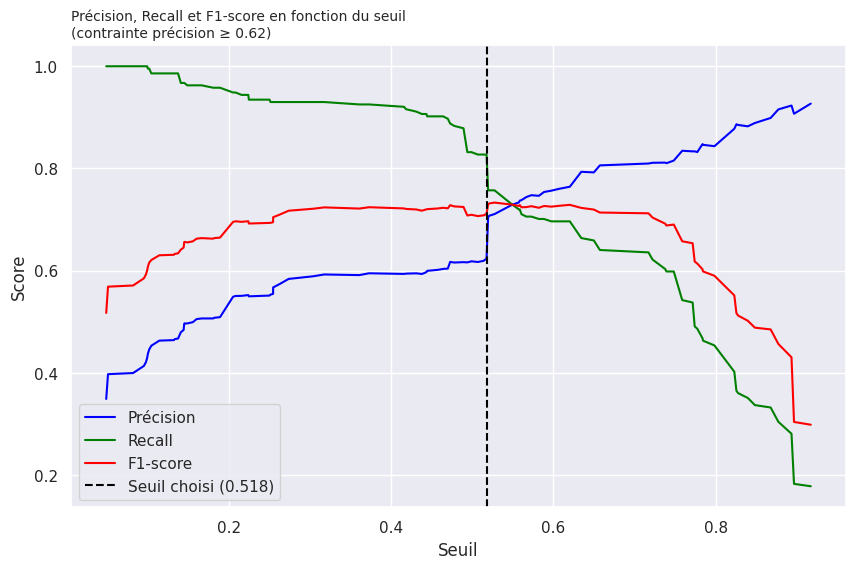

In [242]:
th_stack = evaluate_with_threshold(stack_pipeline, X_train, y_train, X_test, y_test, min_precision=0.62)
# Summary = pd.concat([
#     Summary,
#     compute_resume_scoring(stack_pipeline,"Stacking_0 Smote",X_test,y_test,th_stack)
#     ])

In [57]:
# ## sauvergarde des models
# import joblib
# joblib.dump(best_gb, 'best_gb.pkl')
# joblib.dump(best_lr, 'best_lr.pkl')
# from google.colab import drive; drive.mount('/content/drive')
# # Create the target directory in Google Drive if it doesn't exist
# !mkdir -p "/content/drive/My Drive/Monporfolio/projet/model/"

# # Copy the model to the target directory
# !cp "/content/best_gb.pkl" "/content/drive/My Drive/Monporfolio/projet/model/"
# !cp "/content/best_lr.pkl" "/content/drive/My Drive/Monporfolio/projet/model/"


In [58]:

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# -----------------------------------------------
# Définir SMOTE
# -----------------------------------------------
smote = SMOTE(random_state=42)

# -----------------------------------------------
# Fonction pour Optuna
# -----------------------------------------------
def objective(trial, model_type="rf", X=X_train, y=y_train, use_smote=False):

    # Choix du classifieur
    if model_type == "rf":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt","log2", None]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "class_weight": "balanced"
        }
        model = RandomForestClassifier(**params, random_state=42)

    elif model_type == "gb":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
            "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
            "max_features": trial.suggest_categorical("max_features", ["sqrt","log2", None])
        }
        model = GradientBoostingClassifier(**params, random_state=42)

    else:
        # Logistic Regression
        params = {
            "C": trial.suggest_loguniform("C", 1e-3, 1e3),
            "penalty": trial.suggest_categorical("penalty", ["l2", None]),
            "solver": "lbfgs",
            "max_iter": 1000
        }
        model = LogisticRegression(**params, random_state=42)

    # Pipeline avec ou sans SMOTE
    if use_smote:
        pipe = ImbPipeline([("smote", smote), ("classifier", model)])
    else:
        pipe = ImbPipeline([("classifier", model)])

    score = cross_val_score(
        pipe, X, y,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring="f1",
        n_jobs=-1
    ).mean()

    return score

# -----------------------------------------------
# Optimisation hyperparamètres
# -----------------------------------------------
def optimize_model(model_type="rf", X=X_train, y=y_train, use_smote=False, n_trials=30):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_type, X, y, use_smote), n_trials=n_trials, n_jobs=-1, show_progress_bar=True)
    print(f"=== {model_type.upper()} ({'SMOTE' if use_smote else 'No SMOTE'}) ===")
    print("Best params:", study.best_params)
    print("Best F1-score:", study.best_value)
    return study.best_params

# -----------------------------------------------
# Réentraînement des modèles finaux
# -----------------------------------------------
def train_final_model(best_params, model_type="rf", X=X_train, y=y_train, use_smote=False):
    if model_type == "rf":
        model = RandomForestClassifier(**best_params, random_state=42)
    elif model_type == "gb":
        model = GradientBoostingClassifier(**best_params, random_state=42)
    else:
        model = LogisticRegression(**best_params, random_state=42)

    if use_smote:
        pipe = ImbPipeline([("smote", smote), ("classifier", model)])
    else:
        pipe = ImbPipeline([("classifier", model)])

    pipe.fit(X, y)
    return pipe

# -----------------------------------------------
# Création de l'ensemble (stacking)
# -----------------------------------------------
def build_stacking(X_train, y_train, best_rf, best_gb, best_lr, use_smote=False):
    estimators = [
        ('rf', best_rf),
        ('gb', best_gb),
        ('lr', best_lr)
    ]
    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(),
        cv=StratifiedKFold(n_splits=5),
        n_jobs=-1
    )

    if use_smote:
        pipe = ImbPipeline([("smote", smote), ("stacking", stacking_clf)])
    else:
        pipe = ImbPipeline([("stacking", stacking_clf)])

    pipe.fit(X_train, y_train)
    return pipe

# -----------------------------------------------
# Exemple d'utilisation
# -----------------------------------------------
# Optimisation
best_rf_smote = train_final_model(optimize_model("rf", use_smote=True), "rf", use_smote=True)
best_gb_smote = train_final_model(optimize_model("gb", use_smote=True), "gb", use_smote=True)
best_lr_smote = train_final_model(optimize_model("lr", use_smote=True), "lr", use_smote=True)

best_rf = train_final_model(optimize_model("rf", use_smote=False), "rf")
best_gb = train_final_model(optimize_model("gb", use_smote=False), "gb")
best_lr = train_final_model(optimize_model("lr", use_smote=False), "lr")

# Stacking
stack_smote = build_stacking(X_train, y_train, best_rf_smote, best_gb_smote, best_lr_smote, use_smote=True)
stack_no_smote = build_stacking(X_train, y_train, best_rf, best_gb, best_lr, use_smote=False)

# Évaluation
from sklearn.metrics import classification_report
print("------ Stacking avec SMOTE ------")
print(classification_report(y_test, stack_smote.predict(X_test)))
print("------ Stacking sans SMOTE ------")
print(classification_report(y_test, stack_no_smote.predict(X_test)))


[I 2025-09-11 19:18:17,013] A new study created in memory with name: no-name-63e0ccdf-7a18-4995-ba9a-5d08f7ec4728


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-11 19:18:19,830] Trial 0 finished with value: 0.6620358910291796 and parameters: {'n_estimators': 188, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.6620358910291796.
[I 2025-09-11 19:18:21,154] Trial 1 finished with value: 0.6614731844958673 and parameters: {'n_estimators': 399, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.6620358910291796.
[I 2025-09-11 19:18:22,070] Trial 2 finished with value: 0.6712187754153596 and parameters: {'n_estimators': 281, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.6712187754153596.
[I 2025-09-11 19:18:22,825] Trial 3 finished with value: 0.6748436697437926 and parameters: {'n_estimators': 114, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_feature

[I 2025-09-11 19:19:18,866] A new study created in memory with name: no-name-1f524532-262a-4066-a53c-d9fad427c893


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-11 19:19:22,160] Trial 0 finished with value: 0.6357785714992787 and parameters: {'n_estimators': 118, 'learning_rate': 0.10813677417757889, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 20, 'subsample': 0.6696069344431248, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6357785714992787.
[I 2025-09-11 19:19:22,865] Trial 1 finished with value: 0.6513106776264671 and parameters: {'n_estimators': 409, 'learning_rate': 0.033362518336402226, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.8611487694136406, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6513106776264671.
[I 2025-09-11 19:19:25,142] Trial 2 finished with value: 0.6319347206798319 and parameters: {'n_estimators': 287, 'learning_rate': 0.12904153029756818, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 17, 'subsample': 0.9516491837226426, 'max_features': None}. Best is trial 1 with value: 0.6513106776264671.
[I 2025-09-11 19:19:26,248] Trial 

[I 2025-09-11 19:20:19,840] A new study created in memory with name: no-name-6e3ad4b9-5f0e-46e9-b5da-470da1d4937f


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-11 19:20:19,999] Trial 0 finished with value: 0.6870771700493062 and parameters: {'C': 0.009965835517614683, 'penalty': None}. Best is trial 0 with value: 0.6870771700493062.
[I 2025-09-11 19:20:20,086] Trial 1 finished with value: 0.6870771700493062 and parameters: {'C': 160.47091322416964, 'penalty': None}. Best is trial 0 with value: 0.6870771700493062.
[I 2025-09-11 19:20:20,205] Trial 2 finished with value: 0.6755160528252198 and parameters: {'C': 0.05717827368615249, 'penalty': 'l2'}. Best is trial 0 with value: 0.6870771700493062.
[I 2025-09-11 19:20:20,303] Trial 3 finished with value: 0.6682065138440977 and parameters: {'C': 0.0079675262860068, 'penalty': 'l2'}. Best is trial 0 with value: 0.6870771700493062.
[I 2025-09-11 19:20:20,419] Trial 4 finished with value: 0.6870771700493062 and parameters: {'C': 438.04277977681295, 'penalty': 'l2'}. Best is trial 0 with value: 0.6870771700493062.
[I 2025-09-11 19:20:20,546] Trial 5 finished with value: 0.6770760233918128 a

[I 2025-09-11 19:20:23,225] A new study created in memory with name: no-name-598c8071-ccce-431f-8b02-f6c353372f69


[I 2025-09-11 19:20:23,183] Trial 29 finished with value: 0.6784013012664111 and parameters: {'C': 0.40719479315494383, 'penalty': 'l2'}. Best is trial 0 with value: 0.6870771700493062.
=== LR (SMOTE) ===
Best params: {'C': 0.009965835517614683, 'penalty': None}
Best F1-score: 0.6870771700493062


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-11 19:20:26,452] Trial 0 finished with value: 0.6611383299148043 and parameters: {'n_estimators': 344, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.6611383299148043.
[I 2025-09-11 19:20:29,514] Trial 1 finished with value: 0.6588193557542217 and parameters: {'n_estimators': 446, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.6611383299148043.
[I 2025-09-11 19:20:30,587] Trial 2 finished with value: 0.6079320853693254 and parameters: {'n_estimators': 259, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.6611383299148043.
[I 2025-09-11 19:20:32,690] Trial 3 finished with value: 0.5860145441052791 and parameters: {'n_estimators': 125, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features'

[I 2025-09-11 19:21:24,932] A new study created in memory with name: no-name-d2110577-99cc-44a1-a163-f78e14cc30bd


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-11 19:21:26,096] Trial 0 finished with value: 0.6000715966666871 and parameters: {'n_estimators': 166, 'learning_rate': 0.1726876438862964, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 16, 'subsample': 0.6247366498648003, 'max_features': 'log2'}. Best is trial 0 with value: 0.6000715966666871.
[I 2025-09-11 19:21:27,798] Trial 1 finished with value: 0.6068756745373661 and parameters: {'n_estimators': 389, 'learning_rate': 0.05358992886067711, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 9, 'subsample': 0.8782858371180526, 'max_features': None}. Best is trial 1 with value: 0.6068756745373661.
[I 2025-09-11 19:21:28,298] Trial 2 finished with value: 0.5713662782358241 and parameters: {'n_estimators': 76, 'learning_rate': 0.011094981576647296, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.6980727408886173, 'max_features': None}. Best is trial 1 with value: 0.6068756745373661.
[I 2025-09-11 19:21:30,235] Trial 3 fin

[I 2025-09-11 19:22:11,729] A new study created in memory with name: no-name-c081076f-3f87-4212-93e3-014b54e5d359


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-11 19:22:11,930] Trial 0 finished with value: 0.6506505086168274 and parameters: {'C': 0.0042877523948624055, 'penalty': 'l2'}. Best is trial 0 with value: 0.6506505086168274.
[I 2025-09-11 19:22:11,940] Trial 1 finished with value: 0.6512568870523415 and parameters: {'C': 4.679471036376637, 'penalty': 'l2'}. Best is trial 1 with value: 0.6512568870523415.
[I 2025-09-11 19:22:12,097] Trial 2 finished with value: 0.655968045112782 and parameters: {'C': 0.01451102401609412, 'penalty': 'l2'}. Best is trial 2 with value: 0.655968045112782.
[I 2025-09-11 19:22:12,108] Trial 3 finished with value: 0.6547291092745637 and parameters: {'C': 203.62976479611524, 'penalty': 'l2'}. Best is trial 2 with value: 0.655968045112782.
[I 2025-09-11 19:22:12,235] Trial 4 finished with value: 0.6547291092745637 and parameters: {'C': 0.24002668627058063, 'penalty': None}. Best is trial 2 with value: 0.655968045112782.
[I 2025-09-11 19:22:12,298] Trial 5 finished with value: 0.6512568870523415 and 

----------------------------------------------------------------------------------------------------
============================== Meilleurs modéle entraîné pour l'ensemble learning  ==============================
----------------------------------------------------------------------------------------------------
============================== Modèle avant OverSampling  ==============================
============================== modèle : Gradient Boosting ==============================
----------------------------------------------------------------------------------------------------
Seuil choisi : 0.188 (maximisation du rappel avec précision ≥ 0.6)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.99      0.65      0.78       400
           1       0.60      0.99      0.75       214

    accuracy                           0.77       614
   macro avg       0.79      0.82      0.77     

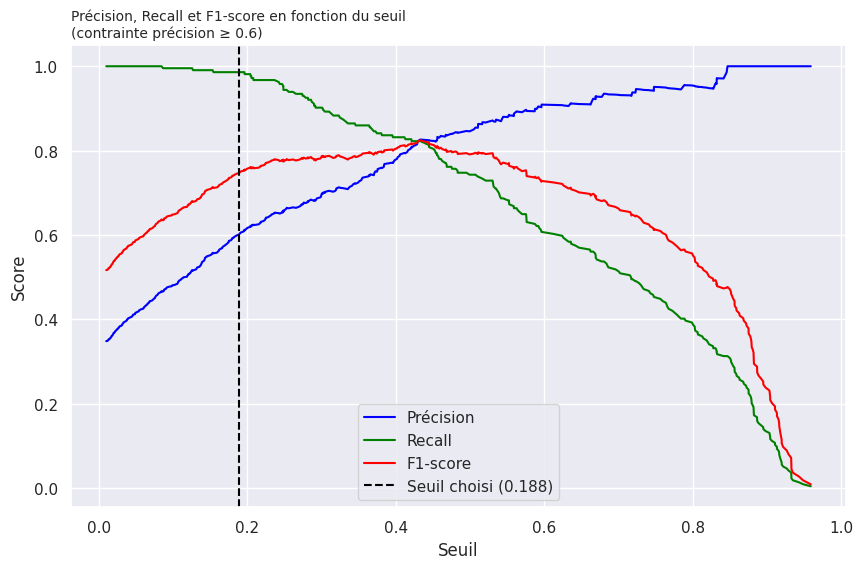

============================== modèle : Regression Logistique ==============================
----------------------------------------------------------------------------------------------------
Seuil choisi : 0.312 (maximisation du rappel avec précision ≥ 0.6)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.86      0.72      0.78       400
           1       0.60      0.77      0.67       214

    accuracy                           0.74       614
   macro avg       0.73      0.75      0.73       614
weighted avg       0.77      0.74      0.75       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       100
           1       0.60      0.81      0.69        54

    accuracy                           0.75       154
   macro avg       0.74      0.76      0.74       1

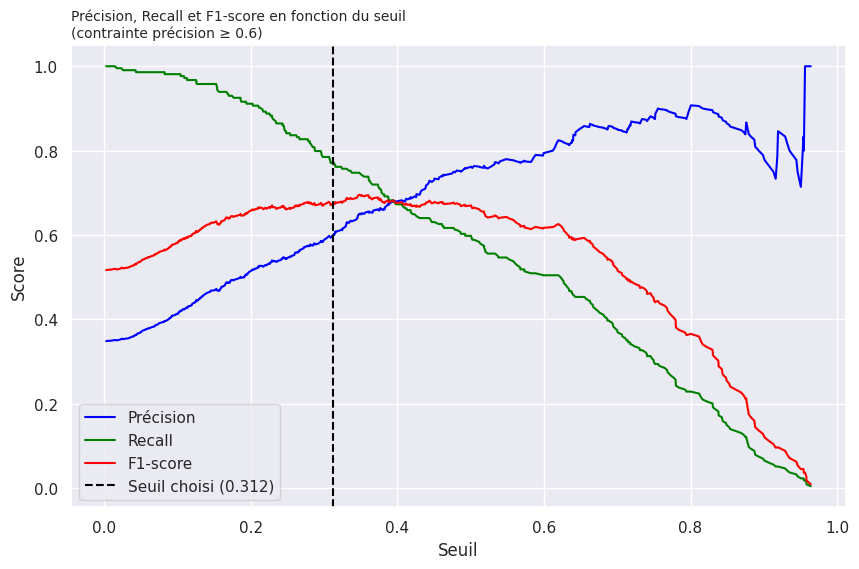

============================== modèle : Random Forest ==============================
----------------------------------------------------------------------------------------------------
Seuil choisi : 0.301 (maximisation du rappel avec précision ≥ 0.75)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       400
           1       0.75      0.99      0.85       214

    accuracy                           0.88       614
   macro avg       0.87      0.91      0.88       614
weighted avg       0.91      0.88      0.88       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.89      0.65      0.75       100
           1       0.57      0.85      0.68        54

    accuracy                           0.72       154
   macro avg       0.73      0.75      0.72       154
weig

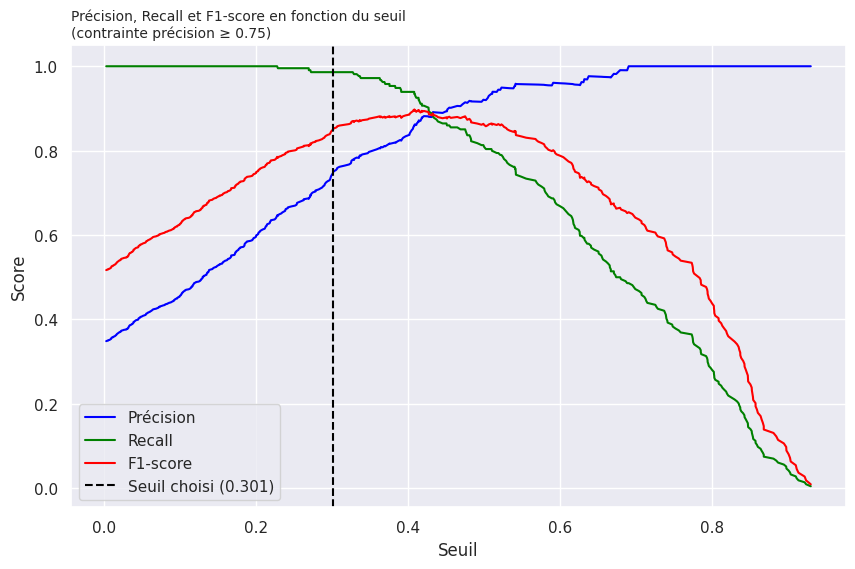

----------------------------------------------------------------------------------------------------
============================== Modèle après OverSampling  ==============================
============================== modèle : Gradient Boosting ==============================
----------------------------------------------------------------------------------------------------
Seuil choisi : 0.454 (maximisation du rappel avec précision ≥ 0.65)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.91      0.76      0.82       400
           1       0.65      0.86      0.74       214

    accuracy                           0.79       614
   macro avg       0.78      0.81      0.78       614
weighted avg       0.82      0.79      0.79       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.90    

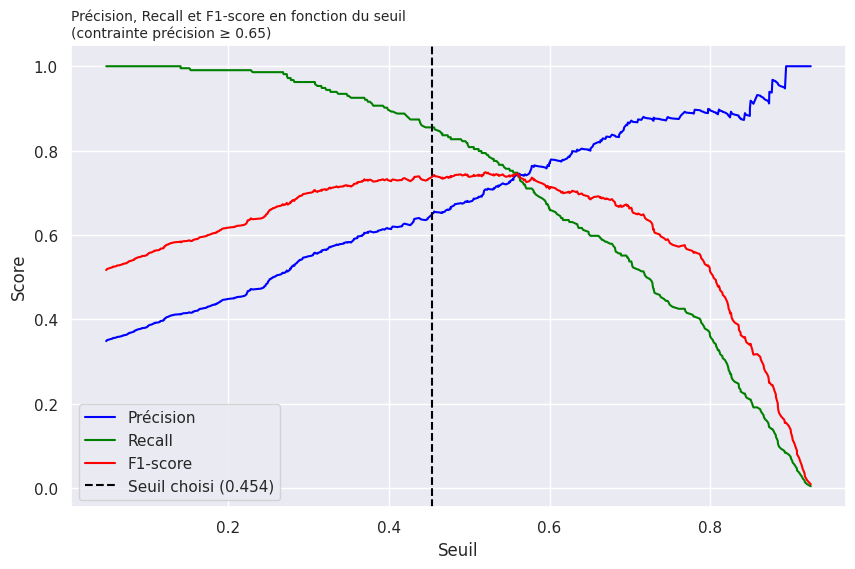

============================== modèle : Regression Logistique ==============================
----------------------------------------------------------------------------------------------------
Seuil choisi : 0.493 (maximisation du rappel avec précision ≥ 0.65)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       400
           1       0.65      0.76      0.70       214

    accuracy                           0.77       614
   macro avg       0.75      0.77      0.76       614
weighted avg       0.79      0.77      0.78       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       100
           1       0.62      0.74      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       

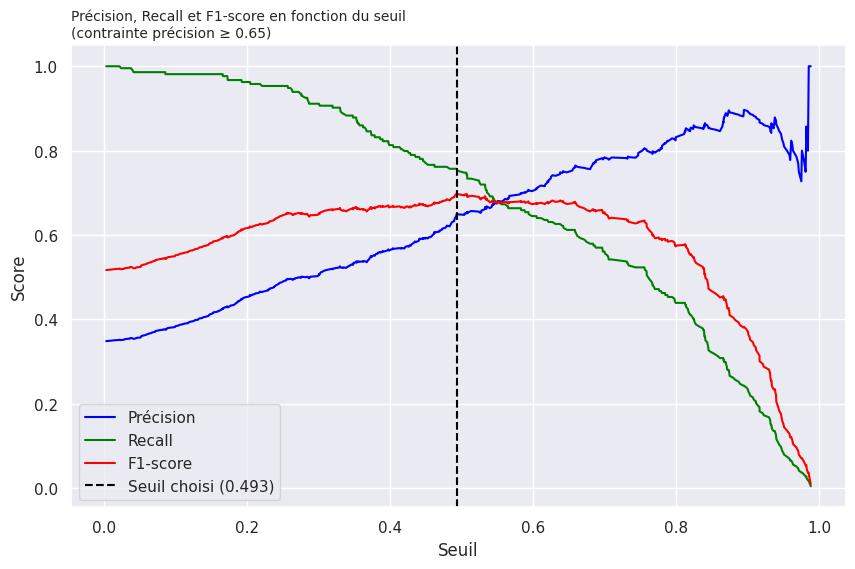

============================== modèle : Random Forest ==============================
----------------------------------------------------------------------------------------------------
Seuil choisi : 0.490 (maximisation du rappel avec précision ≥ 0.8)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       400
           1       0.80      0.94      0.86       214

    accuracy                           0.90       614
   macro avg       0.88      0.91      0.89       614
weighted avg       0.91      0.90      0.90       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       100
           1       0.61      0.76      0.68        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weigh

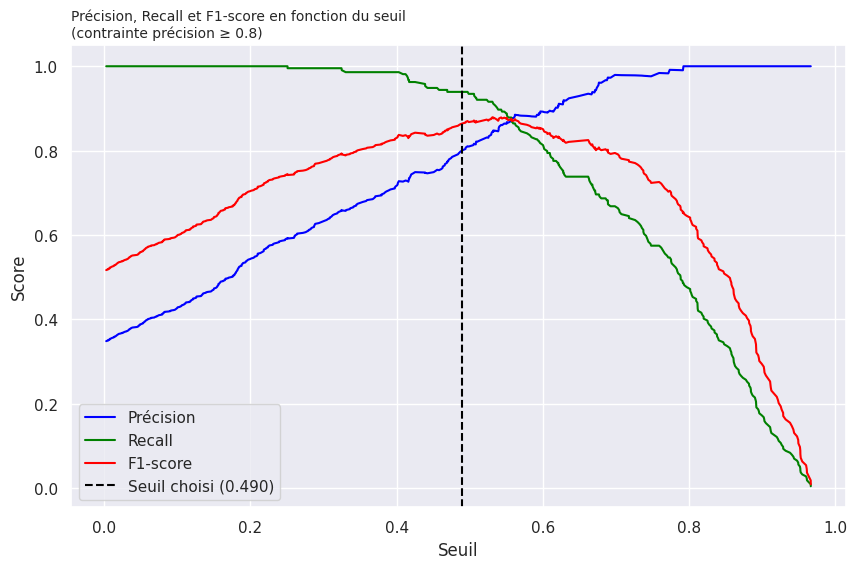

In [207]:
print("--"*50)
print("=="*15 , "Meilleurs modéle entraîné pour l'ensemble learning ","=="*15)
print("--"*50)
print("=="*15,"Modèle avant OverSampling ","=="*15)
print("=="*15 , "modèle : Gradient Boosting","=="*15)
th_gb =evaluate_with_threshold(best_gb, X_train, y_train, X_test, y_test, min_precision= 0.6)
print("=="*15 , "modèle : Regression Logistique","=="*15)
th_lr =evaluate_with_threshold(best_lr, X_train, y_train, X_test, y_test, min_precision=0.6)
print("=="*15 , "modèle : Random Forest","=="*15)
th_rf=evaluate_with_threshold(best_rf, X_train, y_train, X_test, y_test, min_precision=0.75)
print("--"*50)
print("=="*15,"Modèle après OverSampling ","=="*15)
print("=="*15 , "modèle : Gradient Boosting","=="*15)
th_sgb=evaluate_with_threshold(best_gb_smote, X_train, y_train, X_test, y_test, min_precision=0.65)
print("=="*15 , "modèle : Regression Logistique","=="*15)
th_slr=evaluate_with_threshold(best_lr_smote, X_train, y_train, X_test, y_test, min_precision=0.65)
print("=="*15 , "modèle : Random Forest","=="*15)
th_srf =evaluate_with_threshold(best_rf_smote, X_train, y_train, X_test, y_test, min_precision=0.8)
# evaluation_train_test(best_lr, X_train, y_train, X_test, y_test,seuil=0.5)
# evaluation_train_test(best_lr, X_train, y_train, X_test, y_test)

----------------------------------------------------------------------------------------------------
Seuil choisi : 0.374 (maximisation du rappel avec précision ≥ 0.7)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.96      0.79      0.86       400
           1       0.70      0.94      0.80       214

    accuracy                           0.84       614
   macro avg       0.83      0.86      0.83       614
weighted avg       0.87      0.84      0.84       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       100
           1       0.61      0.85      0.71        54

    accuracy                           0.75       154
   macro avg       0.75      0.78      0.75       154
weighted avg       0.79      0.75      0.76       154

-----------------------------------

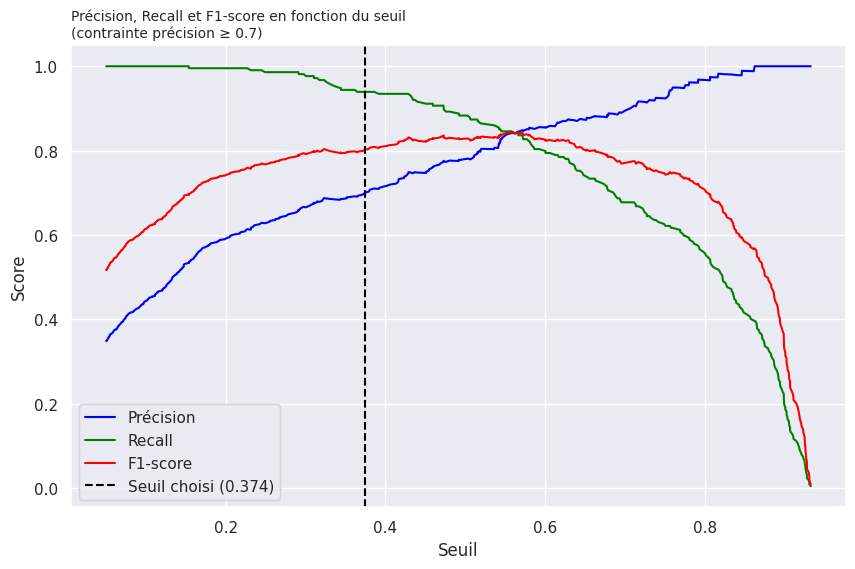

----------------------------------------------------------------------------------------------------
Seuil choisi : 0.190 (maximisation du rappel avec précision ≥ 0.6)
============================== Train set ==============================
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       400
           1       0.60      0.98      0.74       214

    accuracy                           0.77       614
   macro avg       0.79      0.81      0.76       614
weighted avg       0.85      0.77      0.77       614

============================== Test set ==============================
              precision    recall  f1-score   support

           0       0.92      0.58      0.71       100
           1       0.54      0.91      0.68        54

    accuracy                           0.69       154
   macro avg       0.73      0.74      0.69       154
weighted avg       0.79      0.69      0.70       154

-----------------------------------

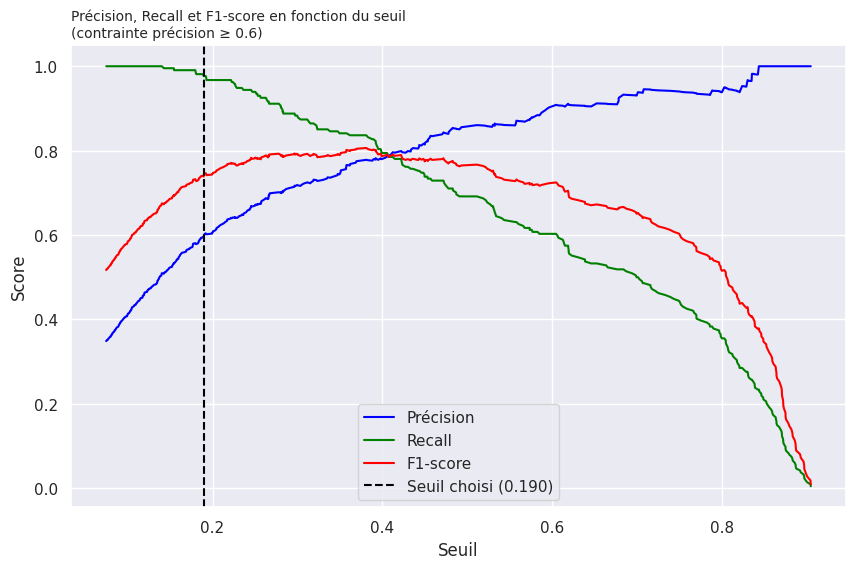

In [210]:
th_stack =evaluate_with_threshold(stack_smote, X_train, y_train, X_test, y_test, min_precision=0.7)
th_sstack =evaluate_with_threshold(stack_no_smote, X_train, y_train, X_test, y_test, min_precision=0.6)

In [270]:
# Summary = pd.concat([
#     compute_resume_scoring(best_gb,"GradientBoosting_stack_1",X_test,y_test,th_gb),
#     compute_resume_scoring(best_lr,"Regression Logistique_stack_1",X_test,y_test,th_lr) ,
#     compute_resume_scoring(best_rf_smote,"Random Forest_stack_1 Smote",X_test,y_test,th_gb),
#     compute_resume_scoring(best_rf,"Random Forest",X_test,y_test,th_rf) ,
#     compute_resume_scoring(best_gb_smote,"GradientBoosting_stack_1 Smote",X_test,y_test,th_sgb),
#     compute_resume_scoring(best_lr_smote,"Regression Logistique_stack_1 Smote",X_test,y_test,th_slr) ,
#     compute_resume_scoring(stack_no_smote,"Stacking_1",X_test,y_test,th_stack) ,
#     compute_resume_scoring(stack_smote,"Stacking_1 Smote",X_test,y_test,th_sstack)

#     ]).reset_index(drop=True)
# # compute_resume_scoring(best_rf,X_test,y_test)],axis=1)

# # Summary.sort_values(by="f1-score")

In [269]:
# Summary.to_csv("Summary.csv")
Summary.sort_values(by="f1-score",ascending=False)
#

Name  precision    recall  f1-score  \
0                         Random Forest   0.633803  0.833333  0.720000   
0        GradientBoosting_stack_0 Smote   0.651515  0.796296  0.716667   
4        GradientBoosting_stack_1 Smote   0.605263  0.851852  0.707692   
0                 Regression_logistique   0.619718  0.814815  0.704000   
0                               XGBoost   0.608108  0.833333  0.703125   
0  Regression Logistique_stack_0 Smote    0.623188  0.796296  0.699187   
1         Regression Logistique_stack_1   0.602740  0.814815  0.692913   
0                      Stacking_0 Smote   0.602740  0.814815  0.692913   
0                     Gradient Boosting   0.597222  0.796296  0.682540   
3                         Random Forest   0.567901  0.851852  0.681481   
7                      Stacking_1 Smote   0.531915  0.925926  0.675676   
5   Regression Logistique_stack_1 Smote   0.615385  0.740741  0.672269   
0              GradientBoosting_stack_1   0.533333  0.888889  0.666667   
2           Random Forest_stack_1 Smote   0.485981  0.962963  0.645963   
6                            Stacking_1   0.651163  0.518519  0.577320   

   Accuracy     Kappa  
0  0.772727  0.534623  
0  0.779221  0.538760  
4  0.753247  0.504572  
0  0.759740  0.508030  
0  0.753247  0.500683  
0  0.759740  0.504091  
1  0.746753  0.485523  
0  0.746753  0.485523  
0  0.740260  0.470244  
3  0.720779  0.450091  
7  0.688312  0.415190  
5  0.746753  0.468778  
0  0.688312  0.406551  
2  0.629870  0.336909  
6  0.733766  0.386633

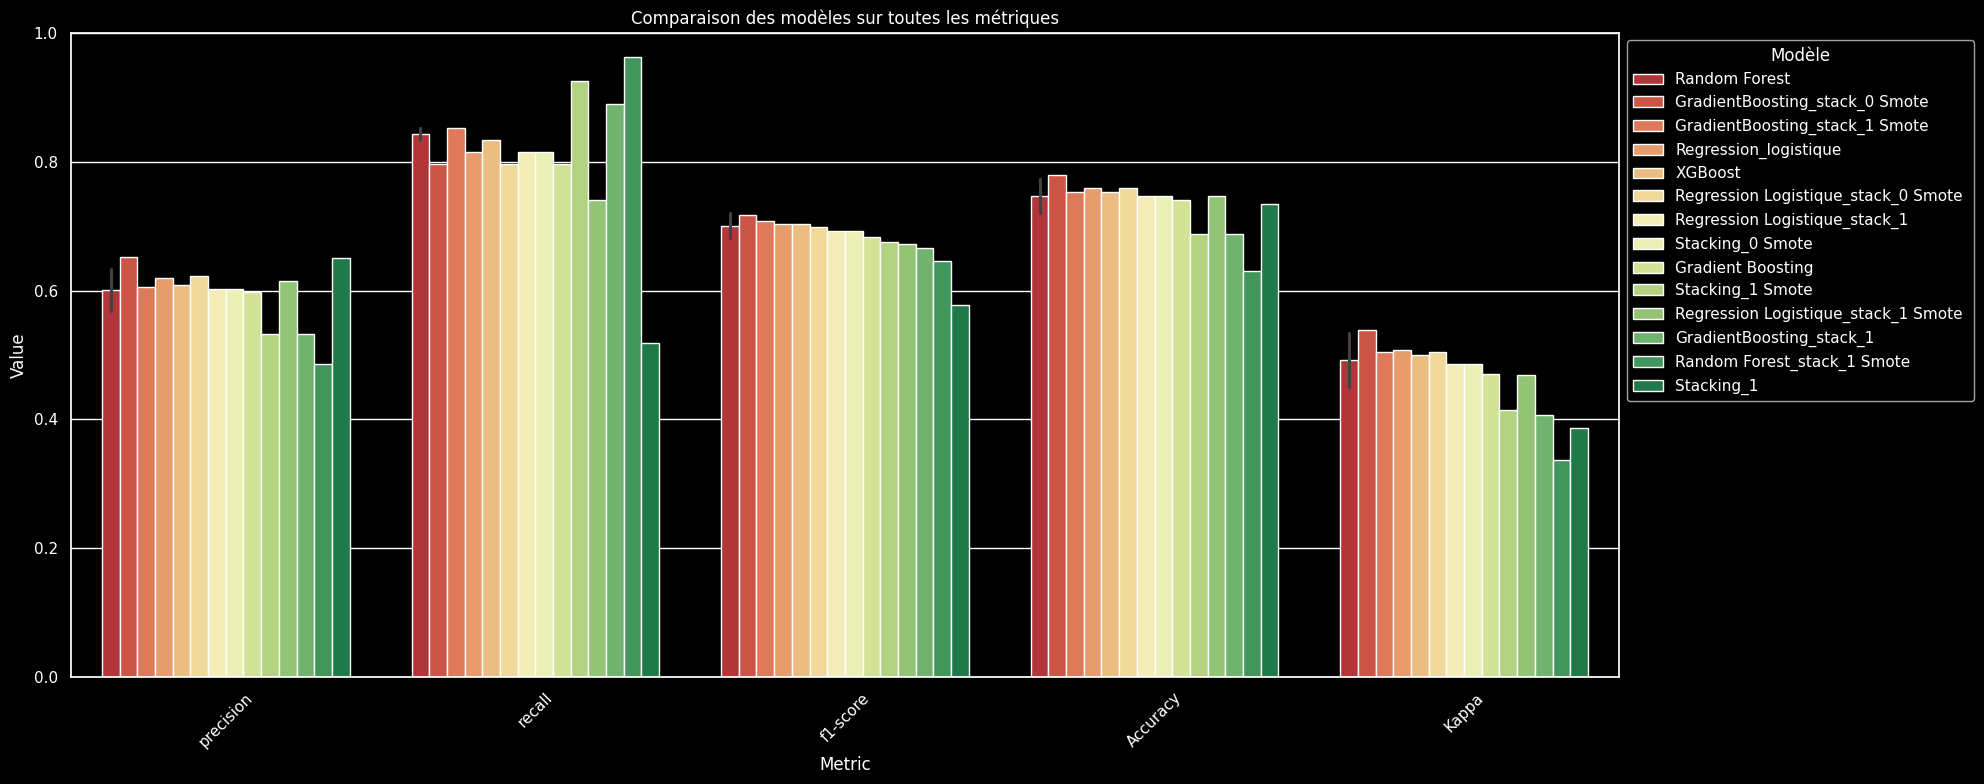

In [323]:
plt.style.use('dark_background')

results_long = Summary.melt(id_vars="Name",
                               var_name="Metric",
                               value_name="Value")
plt.figure(figsize=(20,8))
bar = sns.barplot(data=results_long, x="Metric", y="Value", hue="Name", palette="RdYlGn",hue_order=Summary.sort_values(by="f1-score",ascending=False)["Name"].unique())
plt.title("Comparaison des modèles sur toutes les métriques")
plt.legend(bbox_to_anchor=(1, 1), title="Modèle")
plt.xticks(rotation=45)

# Ajouter les valeurs au-dessus des barres
# for patch in bar.patches:
#     height = patch.get_height()
#     bar.text(patch.get_x() + patch.get_width()/2., height + 0.03,  # léger offset
#              f"{height :.2f} ", ha="center", fontsize=10,color="white")

plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Conclusion Générale

Ce projet a démontré la faisabilité de prédire le diabète chez les femmes Pima à partir de données médicales en utilisant diverses techniques de machine learning. L'analyse exploratoire a révélé des informations précieuses sur les distributions des variables et leurs corrélations avec l'Outcome, mettant en évidence le rôle important du Glucose, du BMI et de l'Age.

Le prétraitement des données, incluant la gestion des valeurs manquantes (mal codées en 0) et la création de nouvelles features, s'est avéré crucial pour améliorer la qualité des données.

Nous avons comparé plusieurs modèles de classification, et les modèles basés sur les arbres (Gradient Boosting, Random Forest) ainsi que la Régression Logistique ont montré les meilleures performances initiales. L'optimisation des hyperparamètres, notamment via Bayesian Optimization et Randomized Search, a permis d'améliorer significativement les scores, en particulier le rappel, qui était notre objectif principal dans un contexte de dépistage médical.

L'ajustement du seuil de décision pour chaque modèle a été une étape clé pour trouver le meilleur compromis entre rappel et précision, en privilégiant la détection maximale des cas diabétiques (haut rappel) tout en maintenant un taux de faux positifs acceptable (précision minimale).

Le Tableau récapitulatif des scores sur le jeu de test avec les seuils ajustés (en particulier `Random Forest` `GradientBoosting_stack_1 Smote` et ` GradientBoosting_stack_0 Smote`) montre que nous avons réussi à atteindre un bon équilibre entre rappel et précision, conformément aux objectifs définis.

**Points clés de <<réussite>> :**

*   Identification et traitement des valeurs aberrantes/manquantes.
*   Exploration approfondie des données et visualisation des relations.
*   Utilisation de techniques d'optimisation d'hyperparamètres avancées (BayesSearchCV, Optuna).
*   Ajustement personnalisé des seuils de décision pour maximiser le rappel selon les contraintes métier.
*   Obtention de modèles performants capables de bien généraliser sur le jeu de test (en particulier `GradientBoosting_stack_1 Smote` avec un rappel de 85% et une précision de 61%).

**Limitations et perspectives :**

*   La taille limitée du jeu de données Pima peut impacter la robustesse et la généralisation des modèles à d'autres populations.
*   Le traitement des valeurs nulles par imputation médiane est une approche simple ; des méthodes plus sophistiquées (e.g., imputation multiple, modèles d'imputation basés sur d'autres variables) pourraient être explorées.
*   Le modèle Random Forest a montré un certain sur-ajustement qui a été atténué mais pourrait nécessiter une régularisation plus poussée ou l'exploration d'autres algorithmes moins sensibles à l'overfitting sur petits datasets.
*   L'ensemble stacking n'a pas apporté d'amélioration significative par rapport aux meilleurs modèles simples, ce qui pourrait être dû à la petite taille du dataset ou à la nécessité d'une optimisation plus poussée du méta-modèle.
*   L'évaluation des modèles pourrait être complétée par d'autres métriques ou analyses (e.g., courbes Lift/Gain, analyse coût-bénéfice des faux positifs/négatifs).

En conclusion, ce projet a démontré la capacité à construire un modèle prédictif de diabète performant sur ce jeu de données spécifique, avec un accent particulier sur la détection des patients (rappel). Les résultats obtenus sont encourageants et les méthodologies appliquées constituent une base solide pour d'éventuels travaux futurs sur des jeux de données plus larges et diversifiés, permettant d'explorer des modèles plus complexes et d'améliorer encore la fiabilité des prédictions dans un contexte clinique réel.

# Ressource

**EDA**

 [Si vous voulez en savoir plus sur la population pima (acces sur le risque du diabète )](https://svt-a-feuillade.fr/pages/doc_spe_Prem/1101602738.)

 **Preprocessing**

 [Outlier capping ](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/)

[Hands on machine learning](https://0-lucas.github.io/digital-garden/99.-Books/Hands-on-Machine-Learning.pdf)

**Modéle et hyperparameter tunning**

Le site scikit-learn (https://scikit-learn.org/stable/)

en ce qui concerne les réglages des paramètres [Cours Udemy](https://www.udemy.com/share/104BdE3@gW-L5TmIseYR0Qh-HtP2bHcjJPK_Rc9a-85_KaXJ9LVk3hCfnNMgITJiMlxDTbkbjw==/)

Optimisation bayésien [si vous voulez en savoir plus](https://datascientest.com/optimisation-baysienne-tout-savoir)


